1 - Cài thư viện

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

!pip -q install -U optuna catboost xgboost extinction joblib

import numpy as np
import pandas as pd
import gc
from joblib import Parallel, delayed
import matplotlib.pyplot as plt

RANDOM_SEED = 42
N_CPU = os.cpu_count()
print("CPU:", N_CPU)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 6.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 MB 14.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 627.8/627.8 kB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.6/248.6 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 85.6 MB/s eta 0:00:00:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xmanager 0.7.1 requires alembic==1.4.3, but you have alembic 1.17.2 which is incompatible.
xmanager 0.7.1 requires sqlalchemy==1.2.19, but you have sqlalchemy 2.0.45 which is incompatible.
CPU: 4


2 - Load data

In [4]:
# load data link
DATA_DIR = "/kaggle/input/mallorn-dataset"

# load log files
train_log = pd.read_csv(f"{DATA_DIR}/train_log.csv")
test_log  = pd.read_csv(f"{DATA_DIR}/test_log.csv")

# load and merge split lightcurves
def load_all_lightcurves(split_file_name: str) -> pd.DataFrame:
    """
    split_file_name : "train_full_lightcurves.csv" or "test_full_lightcurves.csv"
    """
    dfs = []
    for i in range(1, 21):
        split_name = f"split_{i:02d}"
        path = f"{DATA_DIR}/{split_name}/{split_file_name}"
        if os.path.exists(path):
            df_split = pd.read_csv(path)
            dfs.append(df_split)
        else:
            print("Missing:", path)

    all_df = pd.concat(dfs, ignore_index=True)
    return all_df

train_lc = load_all_lightcurves("train_full_lightcurves.csv")
test_lc  = load_all_lightcurves("test_full_lightcurves.csv")

# rename time column
train_lc = train_lc.rename(columns={'Time (MJD)': 'Time'})
test_lc  = test_lc.rename(columns={'Time (MJD)': 'Time'})

print("train_lc:", train_lc.shape, "test_lc:", test_lc.shape)
print("train_log:", train_log.shape, "test_log:", test_log.shape)
train_lc.head()


train_lc: (479384, 5) test_lc: (1145125, 5)
train_log: (3043, 8) test_log: (7135, 7)


,object_id,Time,Flux,Flux_err,Filter
0,Dornhoth_fervain_onodrim,63314.4662,-1.630159,0.365777,z
1,Dornhoth_fervain_onodrim,63780.9674,10.499389,0.253867,r
2,Dornhoth_fervain_onodrim,63789.7693,5.866250,1.559241,y
3,Dornhoth_fervain_onodrim,63794.1702,3.903623,0.376854,r
4,Dornhoth_fervain_onodrim,63794.1702,5.226644,0.516864,i


Khối 3 — De-extinction (EBV) + clean NaN

In [5]:
from extinction import fitzpatrick99

EFF_WL = {'u':3641,'g':4704,'r':6155,'i':7504,'z':8695,'y':10056}

def apply_deextinction(lc_df: pd.DataFrame, log_df: pd.DataFrame) -> pd.DataFrame:
    df = lc_df.copy()
    df = df.merge(log_df[["object_id", "EBV"]], on="object_id", how="left")
    df["EEF_WL"] = df["Filter"].map(EFF_WL)

    EBV = np.asarray(df["EBV"].values, dtype=np.float64)
    wl = np.asarray(df["EEF_WL"].values, dtype=np.float64)
    av = EBV * 3.1

    A_list = []
    for w, av in zip(wl, av):
        # fitzpatrick99 expects array-like wavelength, so pass [w]
        Al = fitzpatrick99(np.array([w], dtype=np.float64), float(av))

        # fitzpatrick99 returns array-like; take scalar
        A_list.append(float(np.asarray(Al).ravel()[0]))
    A_lambda = np.array(A_list, dtype=np.float64)

    df["A_lambda"] = A_lambda
    df["Flux"] = df["Flux"].values * 10**(A_lambda/2.5)
    return df

train_lc = apply_deextinction(train_lc, train_log)
test_lc  = apply_deextinction(test_lc,  test_log)

print("After de-extinction:", train_lc.shape, test_lc.shape)


After de-extinction: (479384, 8) (1145125, 8)


Khối 4 - Feature engineering

In [7]:
from scipy import stats
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C

# -------------------------
# 0) Helpers
# -------------------------
def _finite_mask(*arrs):
    m = None
    for a in arrs:
        a = np.asarray(a, dtype=np.float64)
        mm = np.isfinite(a)
        m = mm if m is None else (m & mm)
    return m if m is not None else np.array([], dtype=bool)

def _safe_percentile(x, q):
    x = np.asarray(x, dtype=np.float64)
    x = x[np.isfinite(x)]
    return float(np.percentile(x, q)) if x.size else 0.0

def _safe_amp(x):
    x = np.asarray(x, dtype=np.float64)
    x = x[np.isfinite(x)]
    return float(np.max(x) - np.min(x)) if x.size else 0.0

def _mad(x):
    x = np.asarray(x, dtype=np.float64)
    x = x[np.isfinite(x)]
    if x.size == 0:
        return 0.0
    med = np.median(x)
    return float(np.median(np.abs(x - med)))

def _cv(x):
    x = np.asarray(x, dtype=np.float64)
    x = x[np.isfinite(x)]
    if x.size < 2:
        return 0.0
    mu = float(np.mean(x))
    sd = float(np.std(x))
    return float(sd / (mu + 1e-6))

def _iqr(x):
    x = np.asarray(x, dtype=np.float64)
    x = x[np.isfinite(x)]
    if x.size < 2:
        return 0.0
    q75, q25 = np.percentile(x, [75, 25])
    return float(q75 - q25)

def _gap_stats(t):
    t = np.asarray(t, dtype=np.float64)
    t = t[np.isfinite(t)]
    if t.size < 3:
        return 0.0, 0.0, 0.0
    t = np.sort(t)
    dt = np.diff(t)
    dt = dt[np.isfinite(dt) & (dt > 0)]
    if dt.size == 0:
        return 0.0, 0.0, 0.0
    return float(np.mean(dt)), float(np.std(dt)), float(np.max(dt))

def global_gap_features(df):
    t = df["Time"].to_numpy(np.float64)
    m = np.isfinite(t)
    t = t[m]
    mu, sd, mx = _gap_stats(t)
    return {"gap_all_mean": mu, "gap_all_std": sd, "gap_all_max": mx}


def variability_indices_features(df, max_points=300):
    # Global (all filters) – cheap, survey-independent style
    sub = df.sort_values("Time")
    t = sub["Time"].to_numpy(np.float64)
    f = sub["Flux"].to_numpy(np.float64)
    e = np.maximum(sub["Flux_err"].to_numpy(np.float64), 1e-6)

    m = _finite_mask(t, f, e)
    t, f, e = t[m], f[m], e[m]
    n = t.size
    if n < 10:
        return {
            "vn_eta": 0.0, "stetson_k": 0.0, "shapiro_w": 0.0,
            "cs_index": 0.0, "A_asym": 0.0,
            "slope_p10": 0.0, "slope_p50": 0.0, "slope_p90": 0.0,
            "abs_slope_p90": 0.0,
        }

    # subsample for Shapiro if too big (Shapiro is ok <= 5k but keep stable/fast)
    if n > max_points:
        sel = np.linspace(0, n - 1, max_points).astype(int)
        t, f, e = t[sel], f[sel], e[sel]
        n = t.size

    mu = np.mean(f)
    r = f - mu
    var = np.var(f) + 1e-12

    # (1) von Neumann eta: sum(diff^2) / ((n-1)*var)
    df1 = np.diff(f)
    vn_eta = float(np.mean(df1 * df1) / var) if df1.size else 0.0

    # (2) Stetson K (single-band form, but we use all points):
    # delta = sqrt(n/(n-1)) * (f-mu)/err ; K = (1/n) sum |delta| / sqrt((1/n) sum delta^2)
    delta = np.sqrt(n / max(n - 1, 1)) * (r / e)
    denom = np.sqrt(np.mean(delta * delta) + 1e-12)
    stetson_k = float(np.mean(np.abs(delta)) / denom) if denom > 0 else 0.0

    # (3) Shapiro-Wilk W on standardized residuals
    rr = (r / (np.std(f) + 1e-12)).astype(np.float64)
    try:
        shapiro_w = float(stats.shapiro(rr).statistic) if (n >= 8 and n <= 3000) else 0.0
    except Exception:
        shapiro_w = 0.0

    # (4) Cumulative-sum index (trend strength)
    z = (r / (np.std(f) + 1e-12))
    cs = np.cumsum(z)
    cs_index = float((cs.max() - cs.min()) / (n + 1e-6))

    # (5) A asymmetry (flux version of UPSILoN A idea)
    rp = r[r > 0]
    rn = r[r < 0]
    sig_p = np.sqrt(np.mean(rp * rp)) if rp.size else 0.0
    sig_n = np.sqrt(np.mean(rn * rn)) if rn.size else 0.0
    A_asym = float(sig_p / (sig_n + 1e-6))

    # (6) slope percentiles (mp10/mp90 inspired, but time-ordered)
    dt = np.diff(t)
    ok = (dt > 0) & np.isfinite(dt) & np.isfinite(df1)
    slopes = (df1[ok] / dt[ok]) if ok.any() else np.array([], dtype=np.float64)

    if slopes.size >= 10:
        slope_p10 = float(np.percentile(slopes, 10))
        slope_p50 = float(np.percentile(slopes, 50))
        slope_p90 = float(np.percentile(slopes, 90))
        abs_slope_p90 = float(np.percentile(np.abs(slopes), 90))
    else:
        slope_p10 = slope_p50 = slope_p90 = abs_slope_p90 = 0.0

    return {
        "vn_eta": vn_eta,
        "stetson_k": stetson_k,
        "shapiro_w": shapiro_w,
        "cs_index": cs_index,
        "A_asym": A_asym,
        "slope_p10": slope_p10,
        "slope_p50": slope_p50,
        "slope_p90": slope_p90,
        "abs_slope_p90": abs_slope_p90,
    }


def blue_dominance_features_from_wide(wide):
    # dùng các cột đã có từ band_agg_features (Khối 5): {band}_flux_max, {band}_flux_amp, {band}_n_obs ...
    # gọi sau khi merge wide_stats + per-object features
    # (TDE brightest in blue; AGN recurring/stochastic) :contentReference[oaicite:7]{index=7} :contentReference[oaicite:8]{index=8}
    for b in ["u","g","r","i","z","y"]:
        for c in [f"{b}_flux_max", f"{b}_flux_amp"]:
            if c not in wide.columns:
                wide[c] = 0.0

    wide["blue_peak_over_red"] = (wide["g_flux_max"] + wide["u_flux_max"]) / (wide["r_flux_max"] + wide["i_flux_max"] + 1e-6)
    wide["blue_amp_over_red"]  = (wide["g_flux_amp"] + wide["u_flux_amp"]) / (wide["r_flux_amp"] + wide["i_flux_amp"] + 1e-6)
    wide["g_over_r_peak"] = wide["g_flux_max"] / (wide["r_flux_max"] + 1e-6)
    wide["u_over_i_peak"] = wide["u_flux_max"] / (wide["i_flux_max"] + 1e-6)
    return wide


def _asinh_scaled(x, scale):
    # scale > 0 để ổn định; asinh chịu được x âm
    x = np.asarray(x, dtype=np.float64)
    return np.arcsinh(x / (scale + 1e-6))

def _binned_band_series(df_band, bin_days=5.0):
    """
    Trả về (t_bin_center, f_bin_median, e_bin_median) cho 1 band
    """
    sub = df_band.sort_values("Time")
    t = sub["Time"].to_numpy(np.float64)
    f = sub["Flux"].to_numpy(np.float64)
    e = np.maximum(sub["Flux_err"].to_numpy(np.float64), 1e-6)

    m = _finite_mask(t, f, e)
    t, f, e = t[m], f[m], e[m]
    if t.size < 6:
        return np.array([], dtype=np.float64), np.array([], dtype=np.float64), np.array([], dtype=np.float64)

    # bin index theo 5 ngày tính từ min time của band đó
    b = np.floor((t - t.min()) / bin_days).astype(np.int64)
    tmp = pd.DataFrame({"b": b, "t": t, "f": f, "e": e})

    gb = tmp.groupby("b", sort=False)
    tbin = gb["t"].median().to_numpy(np.float64)
    fbin = gb["f"].median().to_numpy(np.float64)
    ebin = gb["e"].median().to_numpy(np.float64)

    # sort theo thời gian
    idx = np.argsort(tbin)
    return tbin[idx], fbin[idx], ebin[idx]

def _color_pair_features(t, c, prefix):
    """
    t: time bin center (float array)
    c: color array (float array)
    """
    m = _finite_mask(t, c)
    t, c = t[m], c[m]
    if t.size < 6:
        return {
            f"{prefix}_n": 0.0,
            f"{prefix}_slope": 0.0,
            f"{prefix}_slope_abs": 0.0,
            f"{prefix}_std": 0.0,
            f"{prefix}_mad": 0.0,
            f"{prefix}_range": 0.0,
            f"{prefix}_delta_early_late": 0.0,
        }

    # Center time để fit ổn định
    tt = t - np.median(t)
    slope = float(np.polyfit(tt, c, 1)[0]) if tt.size >= 2 else 0.0

    std = float(np.std(c))
    mad = float(_mad(c))
    crange = float(np.max(c) - np.min(c))

    # early vs late: lấy 25% đầu và 25% cuối theo time
    order = np.argsort(t)
    c_sorted = c[order]
    n = c_sorted.size
    k = max(int(0.25 * n), 1)
    early = float(np.mean(c_sorted[:k]))
    late  = float(np.mean(c_sorted[-k:]))
    delta_early_late = float(late - early)

    return {
        f"{prefix}_n": float(t.size),
        f"{prefix}_slope": slope,
        f"{prefix}_slope_abs": float(abs(slope)),
        f"{prefix}_std": std,
        f"{prefix}_mad": mad,
        f"{prefix}_range": crange,
        f"{prefix}_delta_early_late": delta_early_late,
    }

def color_evolution_features(df, bin_days=5.0):
    """
    Color evolution features cho (u-g) và (g-r) theo thời gian:
    - bin 5 ngày / median flux mỗi bin
    - asinh(flux/scale) để chịu flux âm và giảm outlier
    - fit slope(color vs time), độ ổn định (std/mad), range, early-late shift
    """
    out = {}

    # --- helper lấy series cho band ---
    def get_band(b):
        return _binned_band_series(df[df["Filter"] == b], bin_days=bin_days)

    # u, g, r
    tu, fu, eu = get_band("u")
    tg, fg, eg = get_band("g")
    tr, fr, er = get_band("r")

    # scale: dùng median(|flux|) của band (ổn định hơn so với max)
    su = float(np.median(np.abs(fu))) if fu.size else 0.0
    sg = float(np.median(np.abs(fg))) if fg.size else 0.0
    sr = float(np.median(np.abs(fr))) if fr.size else 0.0

    # chuyển flux -> asinh-scaled
    au = _asinh_scaled(fu, su) if fu.size else np.array([], dtype=np.float64)
    ag = _asinh_scaled(fg, sg) if fg.size else np.array([], dtype=np.float64)
    ar = _asinh_scaled(fr, sr) if fr.size else np.array([], dtype=np.float64)

    # --- u-g: join theo bin time gần nhau (dùng inner-join trên binned times) ---
    if tu.size and tg.size:
        du = pd.DataFrame({"t": tu, "au": au})
        dg = pd.DataFrame({"t": tg, "ag": ag})
        # merge_asof: ghép theo time gần nhất trong 2.5 ngày
        du = du.sort_values("t"); dg = dg.sort_values("t")
        m = pd.merge_asof(du, dg, on="t", direction="nearest", tolerance=bin_days/2)
        m = m.dropna()
        c_ug = (m["au"].to_numpy(np.float64) - m["ag"].to_numpy(np.float64))
        t_ug = m["t"].to_numpy(np.float64)
        out.update(_color_pair_features(t_ug, c_ug, prefix="col_ug"))
    else:
        out.update(_color_pair_features(np.array([]), np.array([]), prefix="col_ug"))

    # --- g-r ---
    if tg.size and tr.size:
        dg = pd.DataFrame({"t": tg, "ag": ag})
        dr = pd.DataFrame({"t": tr, "ar": ar})
        dg = dg.sort_values("t"); dr = dr.sort_values("t")
        m = pd.merge_asof(dg, dr, on="t", direction="nearest", tolerance=bin_days/2)
        m = m.dropna()
        c_gr = (m["ag"].to_numpy(np.float64) - m["ar"].to_numpy(np.float64))
        t_gr = m["t"].to_numpy(np.float64)
        out.update(_color_pair_features(t_gr, c_gr, prefix="col_gr"))
    else:
        out.update(_color_pair_features(np.array([]), np.array([]), prefix="col_gr"))

    # thêm 2 feature “blue stability” tổng hợp:
    # (TDE thường xanh + ít đổi màu) => std/mad/range nhỏ + slope nhỏ
    out["color_stability_mean_std"] = float((out["col_ug_std"] + out["col_gr_std"]) / 2.0)
    out["color_stability_mean_mad"] = float((out["col_ug_mad"] + out["col_gr_mad"]) / 2.0)
    out["color_evol_mean_abs_slope"] = float((out["col_ug_slope_abs"] + out["col_gr_slope_abs"]) / 2.0)

    return out

def _robust_peak_time_from_binned(tbin, ybin, prefer_abs=False):
    """
    Trả t_peak (float) từ series binned.
    prefer_abs=False: peak theo max y
    prefer_abs=True : peak theo max |y|
    """
    tbin = np.asarray(tbin, dtype=np.float64)
    ybin = np.asarray(ybin, dtype=np.float64)
    m = _finite_mask(tbin, ybin)
    tbin, ybin = tbin[m], ybin[m]
    if tbin.size < 3:
        return np.nan
    if prefer_abs:
        i = int(np.argmax(np.abs(ybin)))
    else:
        i = int(np.argmax(ybin))
    return float(tbin[i])


def peak_lag_features(df, bin_days=5.0):
    """
    Peak time lag giữa các band (u,g,r) - rất hữu ích:
    - tpeak_u, tpeak_g, tpeak_r (từ binned median flux)
    - lag_ug = t_u - t_g, lag_gr = t_g - t_r, lag_ur = t_u - t_r
    - abs lag + flags ordering (u trước g trước r...)
    - dùng cả peak theo max(flux) và max(|flux|) để chịu diff imaging/âm

    Output keys:
      tpeak_u, tpeak_g, tpeak_r
      lag_ug, lag_gr, lag_ur, abs_lag_ug, abs_lag_gr, abs_lag_ur
      flag_u_before_g, flag_g_before_r, flag_u_before_r, flag_u_g_r_order
      tpeakabs_u, tpeakabs_g, tpeakabs_r, lagabs_ug, lagabs_gr, lagabs_ur
    """
    out = {}

    def band_series(b):
        t, f, e = _binned_band_series(df[df["Filter"] == b], bin_days=bin_days)
        return t, f, e

    # binned raw flux (median per bin)
    tu, fu, eu = band_series("u")
    tg, fg, eg = band_series("g")
    tr, fr, er = band_series("r")

    # peak times (max flux)
    tpu = _robust_peak_time_from_binned(tu, fu, prefer_abs=False)
    tpg = _robust_peak_time_from_binned(tg, fg, prefer_abs=False)
    tpr = _robust_peak_time_from_binned(tr, fr, prefer_abs=False)

    # peak times (max abs flux)
    tpuA = _robust_peak_time_from_binned(tu, fu, prefer_abs=True)
    tpgA = _robust_peak_time_from_binned(tg, fg, prefer_abs=True)
    tprA = _robust_peak_time_from_binned(tr, fr, prefer_abs=True)

    # pack peaks
    out["tpeak_u"] = float(tpu) if np.isfinite(tpu) else 0.0
    out["tpeak_g"] = float(tpg) if np.isfinite(tpg) else 0.0
    out["tpeak_r"] = float(tpr) if np.isfinite(tpr) else 0.0

    out["tpeakabs_u"] = float(tpuA) if np.isfinite(tpuA) else 0.0
    out["tpeakabs_g"] = float(tpgA) if np.isfinite(tpgA) else 0.0
    out["tpeakabs_r"] = float(tprA) if np.isfinite(tprA) else 0.0

    # lags helper
    def lag(a, b):
        if (not np.isfinite(a)) or (not np.isfinite(b)):
            return 0.0
        return float(a - b)

    # lags (max flux peaks)
    out["lag_ug"] = lag(tpu, tpg)
    out["lag_gr"] = lag(tpg, tpr)
    out["lag_ur"] = lag(tpu, tpr)
    out["abs_lag_ug"] = float(abs(out["lag_ug"]))
    out["abs_lag_gr"] = float(abs(out["lag_gr"]))
    out["abs_lag_ur"] = float(abs(out["lag_ur"]))

    # lags (max abs peaks)
    out["lagabs_ug"] = lag(tpuA, tpgA)
    out["lagabs_gr"] = lag(tpgA, tprA)
    out["lagabs_ur"] = lag(tpuA, tprA)
    out["abs_lagabs_ug"] = float(abs(out["lagabs_ug"]))
    out["abs_lagabs_gr"] = float(abs(out["lagabs_gr"]))
    out["abs_lagabs_ur"] = float(abs(out["lagabs_ur"]))

    # ordering flags (dạng 0/1, tree rất thích)
    def flag(cond):
        return float(1.0 if cond else 0.0)

    # dùng peak max-flux nếu có đủ, nếu không fallback sang abs-peak
    uu = tpu if np.isfinite(tpu) else tpuA
    gg = tpg if np.isfinite(tpg) else tpgA
    rr = tpr if np.isfinite(tpr) else tprA

    if np.isfinite(uu) and np.isfinite(gg):
        out["flag_u_before_g"] = flag(uu < gg)
    else:
        out["flag_u_before_g"] = 0.0

    if np.isfinite(gg) and np.isfinite(rr):
        out["flag_g_before_r"] = flag(gg < rr)
    else:
        out["flag_g_before_r"] = 0.0

    if np.isfinite(uu) and np.isfinite(rr):
        out["flag_u_before_r"] = flag(uu < rr)
    else:
        out["flag_u_before_r"] = 0.0

    if np.isfinite(uu) and np.isfinite(gg) and np.isfinite(rr):
        out["flag_u_g_r_order"] = flag((uu < gg) and (gg < rr))
    else:
        out["flag_u_g_r_order"] = 0.0

    # thêm “peak lag magnitude summary”
    out["peak_lag_mean_abs"] = float((out["abs_lag_ug"] + out["abs_lag_gr"] + out["abs_lag_ur"]) / 3.0)
    out["peak_lagabs_mean_abs"] = float((out["abs_lagabs_ug"] + out["abs_lagabs_gr"] + out["abs_lagabs_ur"]) / 3.0)

    return out


def flare_baseline_features(df, z=None, bin_days=5.0, peak_window_days=100.0):
    """
    Tách baseline vs flare (cực hữu ích tách AGN vs transient):
    - xác định t_peak theo max |flux| trên toàn bộ (binned all)
    - baseline = ngoài cửa sổ [t_peak - W, t_peak + W]
    - flare    = trong cửa sổ đó
    - tính strength = (peak - median_baseline) / (mad_baseline)
    - và các tỷ lệ: frac points in flare, std ratio, mad ratio, etc.
    - dùng asinh(flux/scale) để ổn định khi flux âm/outlier

    z (optional): nếu truyền z, có thêm window restframe ~ W/(1+z)
    Output keys:
      fb_tpeak_abs, fb_scale, fb_n_base, fb_n_flare, fb_frac_flare
      fb_base_mad, fb_flare_mad, fb_mad_ratio
      fb_base_std, fb_flare_std, fb_std_ratio
      fb_base_med, fb_flare_med, fb_peak, fb_peak_minus_base
      fb_strength_mad, fb_strength_std
      fb_base_neg_frac, fb_flare_neg_frac
    """
    sub = df.sort_values("Time")
    t = sub["Time"].to_numpy(np.float64)
    f = sub["Flux"].to_numpy(np.float64)
    e = np.maximum(sub["Flux_err"].to_numpy(np.float64), 1e-6)

    m = _finite_mask(t, f, e)
    t, f, e = t[m], f[m], e[m]
    if t.size < 12:
        return {
            "fb_tpeak_abs": 0.0, "fb_scale": 0.0,
            "fb_n_base": 0.0, "fb_n_flare": 0.0, "fb_frac_flare": 0.0,
            "fb_base_mad": 0.0, "fb_flare_mad": 0.0, "fb_mad_ratio": 0.0,
            "fb_base_std": 0.0, "fb_flare_std": 0.0, "fb_std_ratio": 0.0,
            "fb_base_med": 0.0, "fb_flare_med": 0.0, "fb_peak": 0.0, "fb_peak_minus_base": 0.0,
            "fb_strength_mad": 0.0, "fb_strength_std": 0.0,
            "fb_base_neg_frac": 0.0, "fb_flare_neg_frac": 0.0,
        }

    # binned all-band series để tìm peak ổn định hơn
    # (bin theo time min của object)
    b = np.floor((t - t.min()) / bin_days).astype(np.int64)
    tmp = pd.DataFrame({"b": b, "t": t, "f": f, "e": e})
    gb = tmp.groupby("b", sort=False)
    tbin = gb["t"].median().to_numpy(np.float64)
    fbin = gb["f"].median().to_numpy(np.float64)

    # peak theo max |flux| để chịu diff imaging
    m2 = _finite_mask(tbin, fbin)
    tbin, fbin = tbin[m2], fbin[m2]
    if tbin.size < 3:
        t_peak = float(t[np.argmax(np.abs(f))])
    else:
        t_peak = float(tbin[int(np.argmax(np.abs(fbin)))])

    # scale cho asinh: median(|flux|) toàn object
    scale = float(np.median(np.abs(f))) if f.size else 0.0
    y = _asinh_scaled(f, scale)

    # rest-frame window nếu có z
    W = float(peak_window_days)
    if z is not None:
        try:
            zz = float(z)
            if np.isfinite(zz) and zz > -0.5:
                W = float(W / (1.0 + max(zz, 0.0)))
        except Exception:
            pass

    in_flare = (t >= (t_peak - W)) & (t <= (t_peak + W))
    in_base = ~in_flare

    # nếu baseline quá ít -> fallback baseline = 30% thời gian đầu/cuối
    if in_base.sum() < 6:
        order = np.argsort(t)
        n = t.size
        k = max(int(0.3 * n), 1)
        base_idx = np.zeros(n, dtype=bool)
        base_idx[order[:k]] = True
        base_idx[order[-k:]] = True
        in_base = base_idx
        in_flare = ~in_base

    y_base = y[in_base]
    y_flare = y[in_flare]

    # robust stats
    base_med = float(np.median(y_base)) if y_base.size else 0.0
    flare_med = float(np.median(y_flare)) if y_flare.size else 0.0
    base_mad = float(_mad(y_base)) if y_base.size else 0.0
    flare_mad = float(_mad(y_flare)) if y_flare.size else 0.0
    base_std = float(np.std(y_base)) if y_base.size else 0.0
    flare_std = float(np.std(y_flare)) if y_flare.size else 0.0

    # peak value (asinh) lấy từ raw (không binned) để "strength" rõ
    y_peak = float(y[int(np.argmax(np.abs(f)))]) if y.size else 0.0

    # strength: peak above baseline
    peak_minus_base = float(y_peak - base_med)
    strength_mad = float(peak_minus_base / (base_mad + 1e-6))
    strength_std = float(peak_minus_base / (base_std + 1e-6))

    # neg frac (trên raw flux, không asinh)
    base_neg = float(np.mean(f[in_base] < 0)) if in_base.sum() else 0.0
    flare_neg = float(np.mean(f[in_flare] < 0)) if in_flare.sum() else 0.0

    out = {
        "fb_tpeak_abs": float(t_peak),
        "fb_scale": float(scale),
        "fb_n_base": float(in_base.sum()),
        "fb_n_flare": float(in_flare.sum()),
        "fb_frac_flare": float(in_flare.mean()),
        "fb_base_mad": float(base_mad),
        "fb_flare_mad": float(flare_mad),
        "fb_mad_ratio": float(flare_mad / (base_mad + 1e-6)),
        "fb_base_std": float(base_std),
        "fb_flare_std": float(flare_std),
        "fb_std_ratio": float(flare_std / (base_std + 1e-6)),
        "fb_base_med": float(base_med),
        "fb_flare_med": float(flare_med),
        "fb_peak": float(y_peak),
        "fb_peak_minus_base": float(peak_minus_base),
        "fb_strength_mad": float(strength_mad),
        "fb_strength_std": float(strength_std),
        "fb_base_neg_frac": float(base_neg),
        "fb_flare_neg_frac": float(flare_neg),
    }

    # thêm 1 feature kiểu “transientness”: flare scatter nhỏ hơn baseline hay không
    # (AGN baseline biến thiên, transient flare tập trung quanh peak)
    out["fb_transientness"] = float((base_std + 1e-6) / (flare_std + 1e-6))

    return out


# -------------------------
# 1) SNR / detection-like quality features
# -------------------------
def quality_features(df):
    """
    Very important features (takenotes):
    - total_s2n (sum |snr|)
    - frac_s2n_pos5, frac_s2n_neg5
    - frac_background (|snr|<3)
    - time_width_s2n_5  (Boone-like)
    """
    t = df["Time"].to_numpy(np.float64)
    f = df["Flux"].to_numpy(np.float64)
    e = np.maximum(df["Flux_err"].to_numpy(np.float64), 1e-6)

    m = _finite_mask(t, f, e)
    if m.sum() == 0:
        return {"total_s2n":0.0, "frac_s2n_pos5":0.0, "frac_s2n_neg5":0.0,
                "frac_background":1.0, "time_width_s2n_5":0.0}

    t, f, e = t[m], f[m], e[m]
    snr = f / e
    snr = snr[np.isfinite(snr)]
    if snr.size == 0:
        return {"total_s2n":0.0, "frac_s2n_pos5":0.0, "frac_s2n_neg5":0.0,
                "frac_background":1.0, "time_width_s2n_5":0.0}

    out = {
        "total_s2n": float(np.sum(np.abs(snr))),
        "frac_s2n_pos5": float(np.mean(snr > 5)),
        "frac_s2n_neg5": float(np.mean(snr < -5)),
        "frac_background": float(np.mean(np.abs(snr) < 3)),
    }

    m5 = (snr > 5)
    out["time_width_s2n_5"] = float(t[m5].max() - t[m5].min()) if m5.sum() >= 2 else 0.0
    return out


def snr_ratio_sets_features(df):
    """
    Features on subsets by ratio = abs(flux)/err:
      all, ratio>3, ratio>4, ratio>5
    """
    t = df["Time"].to_numpy(np.float64)
    f = df["Flux"].to_numpy(np.float64)
    e = np.maximum(df["Flux_err"].to_numpy(np.float64), 1e-6)

    m = _finite_mask(t, f, e)
    if m.sum() == 0:
        return {f"{k}_{s}": 0.0 for k in ["ratio_mean","ratio_std","mjd_var","mjd_width","nobs"]
                                  for s in ["all","r3","r4","r5"]}

    t, f, e = t[m], f[m], e[m]
    ratio = np.abs(f) / e

    def pack(mask, suf):
        if mask.sum() < 3:
            return {f"ratio_mean_{suf}":0.0, f"ratio_std_{suf}":0.0,
                    f"mjd_var_{suf}":0.0, f"mjd_width_{suf}":0.0,
                    f"nobs_{suf}":0.0}
        tt = t[mask]; rr = ratio[mask]
        return {
            f"ratio_mean_{suf}": float(np.mean(rr)),
            f"ratio_std_{suf}": float(np.std(rr)),
            f"mjd_var_{suf}": float(np.var(tt)),
            f"mjd_width_{suf}": float(tt.max() - tt.min()),
            f"nobs_{suf}": float(mask.sum()),
        }

    out = {}
    out.update(pack(np.ones_like(ratio, dtype=bool), "all"))
    out.update(pack(ratio > 3, "r3"))
    out.update(pack(ratio > 4, "r4"))
    out.update(pack(ratio > 5, "r5"))

    # remove exact duplicates with other features
    out.pop("mjd_width_r5", None)   # duplicates time_width_s2n_5_cov
    out.pop("mjd_width_all", None)  # duplicates global_duration

    return out


def duration_over_snr(df, bands=None, thr=5.0):
    sub = df if bands is None else df[df["Filter"].isin(bands)]
    if len(sub) < 5:
        return 0.0
    t = sub["Time"].to_numpy(np.float64)
    f = sub["Flux"].to_numpy(np.float64)
    e = np.maximum(sub["Flux_err"].to_numpy(np.float64), 1e-6)
    m = _finite_mask(t, f, e)
    t, f, e = t[m], f[m], e[m]
    if t.size < 5:
        return 0.0
    snr = np.abs(f) / e
    hi = snr > thr
    return float(t[hi].max() - t[hi].min()) if hi.sum() >= 2 else 0.0

def window_duration_features(df, z_value):
    z = float(z_value) if np.isfinite(z_value) else 0.0
    onepz = 1.0 + max(z, 0.0)

    dur5_all = duration_over_snr(df, bands=None, thr=5.0)
    dur3_all = duration_over_snr(df, bands=None, thr=3.0)

    dur5_blue = duration_over_snr(df, bands=["u","g"], thr=5.0)
    dur5_red  = duration_over_snr(df, bands=["r","i"], thr=5.0)

    return {
        "dur5_all_rest": dur5_all / onepz,
        "dur3_all_rest": dur3_all / onepz,
        "dur5_blue_rest": dur5_blue / onepz,
        "dur5_red_rest": dur5_red / onepz,
        "dur5_blue_over_red": (dur5_blue + 1e-6) / (dur5_red + 1e-6),
    }

# -------------------------
# 2) Coverage around peak + peak counts (Boone style)
# -------------------------
def peak_count_features(df):
    """
    V1 feature set (strong):
    peak at max Flux (not abs) + counts around peak
    """
    f = df["Flux"].to_numpy(np.float64)
    t = df["Time"].to_numpy(np.float64)
    m = _finite_mask(t, f)
    t, f = t[m], f[m]
    if t.size == 0:
        return {"t_peak_all":0.0, "f_peak_all":0.0,
                "count_max_center":0.0,
                "count_max_rise_20":0.0,"count_max_rise_50":0.0,"count_max_rise_100":0.0,
                "count_max_fall_20":0.0,"count_max_fall_50":0.0,"count_max_fall_100":0.0}

    i = int(np.argmax(f))
    t_peak = float(t[i])
    f_peak = float(f[i])

    out = {"t_peak_all": t_peak, "f_peak_all": f_peak}
    out["count_max_center"] = float(np.sum(np.abs(t - t_peak) <= 5))

    for w in [20, 50, 100]:
        out[f"count_max_rise_{w}"] = float(np.sum((t >= t_peak - w) & (t <= t_peak + 5)))
        out[f"count_max_fall_{w}"] = float(np.sum((t >= t_peak - 5) & (t <= t_peak + w)))
    return out


def peak_coverage_features(df):
    """
    V1 coverage feature set:
    - peak chosen by max |flux| (more robust when flux can be negative)
    - includes time_width_s2n_5 based on abs(f)/e > 5
    - count windows around peak
    """
    sub = df.sort_values("Time")
    t = sub["Time"].to_numpy(np.float64)
    f = sub["Flux"].to_numpy(np.float64)
    e = np.maximum(sub["Flux_err"].to_numpy(np.float64), 1e-6)

    m = _finite_mask(t, f, e)
    t, f, e = t[m], f[m], e[m]
    if t.size < 5:
        return {
            "time_width_s2n_5_cov": 0.0,
            "cov_count_center": 0.0,
            "cov_count_rise_20": 0.0, "cov_count_rise_50": 0.0, "cov_count_rise_100": 0.0,
            "cov_count_fall_20": 0.0, "cov_count_fall_50": 0.0, "cov_count_fall_100": 0.0,
        }

    snr_abs = np.abs(f) / e
    hi = snr_abs > 5
    time_width = float(t[hi].max() - t[hi].min()) if hi.sum() >= 2 else 0.0

    t_peak = float(t[np.argmax(np.abs(f))])

    def cnt(a, b):
        return float(np.sum((t >= t_peak + a) & (t <= t_peak + b)))

    return {
        "time_width_s2n_5_cov": time_width,
        "cov_count_center": cnt(-5, 5),
        "cov_count_rise_20": cnt(-20, 5),
        "cov_count_rise_50": cnt(-50, 5),
        "cov_count_rise_100": cnt(-100, 5),
        "cov_count_fall_20": cnt(-5, 20),
        "cov_count_fall_50": cnt(-5, 50),
        "cov_count_fall_100": cnt(-5, 100),
    }


def peak_frac_2_feature(df):
    """
    V1: bin 5-day mean flux, compute 2nd highest / highest.
    Useful for multi-peak or AGN-ish variability.
    """
    sub = df.sort_values("Time")
    t = sub["Time"].to_numpy(np.float64)
    f = sub["Flux"].to_numpy(np.float64)
    m = _finite_mask(t, f)
    t, f = t[m], f[m]
    if f.size < 20:
        return {"peak_frac_2": 0.0}

    bins = np.floor((t - t.min()) / 5.0).astype(int)
    b = pd.DataFrame({"b": bins, "f": f}).groupby("b")["f"].mean().to_numpy(np.float64)
    if b.size < 5:
        return {"peak_frac_2": 0.0}

    top2 = np.sort(b)[-2:]
    main = float(top2[-1])
    second = float(top2[-2]) if top2.size > 1 else 0.0
    return {"peak_frac_2": float(second / (main + 1e-6))}


# -------------------------
# 3) Percentile shape / tails
# -------------------------
def percentile_diff_features(df):
    """
    V1: per band compute normalized percentile diffs around p50, then median across bands.
    Keys: percentile_diff_{10,30,70,90}_50
    """
    feats = []
    for flt, sub in df.groupby("Filter"):
        x = sub["Flux"].to_numpy(np.float64)
        x = x[np.isfinite(x)]
        if x.size < 10:
            continue
        # p10, p30, p50, p70, p90 = np.percentile(x, [10, 30, 50, 70, 90])
        p10 = _safe_percentile(x, 10)
        p30 = _safe_percentile(x, 30)
        p50 = _safe_percentile(x, 50)
        p70 = _safe_percentile(x, 70)
        p90 = _safe_percentile(x, 90)
        amp = (np.max(x) - np.min(x)) + 1e-6
        feats.append([(p10 - p50)/amp, (p30 - p50)/amp, (p70 - p50)/amp, (p90 - p50)/amp])

    if len(feats) == 0:
        return {f"percentile_diff_{k}_50": 0.0 for k in [10,30,70,90]}

    med = np.median(np.asarray(feats), axis=0)
    return {
        "percentile_diff_10_50": float(med[0]),
        "percentile_diff_30_50": float(med[1]),
        "percentile_diff_70_50": float(med[2]),
        "percentile_diff_90_50": float(med[3]),
    }


def robust_baseline_features(df):
    """
    Robust baseline per band (median) + stats on flux_centered, then median across bands.
    """
    feats = []
    for flt, sub in df.groupby("Filter"):
        f = sub["Flux"].to_numpy(np.float64)
        f = f[np.isfinite(f)]
        if f.size < 5:
            continue
        base = np.median(f)
        fc = f - base
        amp = _safe_amp(fc)
        # p10, p50, p90 = np.percentile(fc, [10, 50, 90])
        p10 = _safe_percentile(fc, 10)
        p50 = _safe_percentile(fc, 50)
        p90 = _safe_percentile(fc, 90)
        feats.append([base, amp, np.mean(fc), np.std(fc), np.mean(fc < 0), p10, p50, p90])

    if len(feats) == 0:
        return {
            "base_med": 0.0, "amp_med": 0.0, "fc_mean_med": 0.0, "fc_std_med": 0.0,
            "neg_frac_med": 0.0, "p10_med": 0.0, "p50_med": 0.0, "p90_med": 0.0
        }

    med = np.median(np.asarray(feats), axis=0)
    return {
        "base_med": float(med[0]),
        "amp_med": float(med[1]),
        "fc_mean_med": float(med[2]),
        "fc_std_med": float(med[3]),
        "neg_frac_med": float(med[4]),
        "p10_med": float(med[5]),
        "p50_med": float(med[6]),
        "p90_med": float(med[7]),
    }


def percentile_tail_features(df):
    """
    V1: tails on centered flux, then median across bands:
      tail_hi=(p90-p50)/amp, tail_lo=(p50-p10)/amp, tail_asym=tail_hi-tail_lo
    """
    feats = []
    for flt, sub in df.groupby("Filter"):
        f = sub["Flux"].to_numpy(np.float64)
        f = f[np.isfinite(f)]
        if f.size < 8:
            continue
        base = np.median(f)
        fc = f - base
        amp = _safe_amp(fc) + 1e-6
        # p10, p50, p90 = np.percentile(fc, [10, 50, 90])
        p10 = _safe_percentile(fc, 10)
        p50 = _safe_percentile(fc, 50)
        p90 = _safe_percentile(fc, 90)

        tail_hi = (p90 - p50) / amp
        tail_lo = (p50 - p10) / amp
        feats.append([tail_hi, tail_lo, tail_hi - tail_lo])

    if len(feats) == 0:
        return {"tail_hi": 0.0, "tail_lo": 0.0, "tail_asym": 0.0}

    med = np.median(np.asarray(feats), axis=0)
    return {"tail_hi": float(med[0]), "tail_lo": float(med[1]), "tail_asym": float(med[2])}


# -------------------------
# 4) Curve angle (fast shape)
# -------------------------
def curve_angle_features(df):
    """
    Compute angle = arctan(dFlux/dTime) per band, then take median across bands.
    """
    feats = []
    for flt, sub in df.groupby("Filter"):
        sub = sub.sort_values("Time")
        t = sub["Time"].to_numpy(np.float64)
        f = sub["Flux"].to_numpy(np.float64)
        m = _finite_mask(t, f)
        t, f = t[m], f[m]
        if t.size < 8:
            continue
        dt = np.diff(t)
        dfu = np.diff(f)
        m2 = (dt > 0) & np.isfinite(dt) & np.isfinite(dfu)
        if m2.sum() < 5:
            continue
        slope = dfu[m2] / dt[m2]
        ang = np.arctan(slope)
        feats.append([
            np.mean(np.abs(ang)),
            np.std(ang),
            # np.percentile(ang, 10),
            # np.percentile(ang, 50),
            # np.percentile(ang, 90),
            _safe_percentile(ang, 10), 
            _safe_percentile(ang, 50), 
            _safe_percentile(ang, 90),
        ])

    if len(feats) == 0:
        return {"angle_abs_mean":0.0,"angle_std":0.0,"angle_p10":0.0,"angle_p50":0.0,"angle_p90":0.0}

    med = np.median(np.asarray(feats), axis=0)
    return {"angle_abs_mean": float(med[0]),
            "angle_std": float(med[1]),
            "angle_p10": float(med[2]),
            "angle_p50": float(med[3]),
            "angle_p90": float(med[4])}


# -------------------------
# 5) TDE physics: power-law decline + asymmetry
# -------------------------
def powerlaw_alpha(time, flux, t_peak):
    """
    V1 version (more robust guards):
    Fit log(flux) ~ a*log(dt) + b for dt>0, flux>0 after peak.
    Return (alpha=a, r2, npts)
    """
    time = np.asarray(time, dtype=np.float64)
    flux = np.asarray(flux, dtype=np.float64)

    m = _finite_mask(time, flux)
    time, flux = time[m], flux[m]
    if time.size < 12:
        return 0.0, 0.0, 0

    m_after = time > t_peak
    if m_after.sum() < 8:
        return 0.0, 0.0, int(m_after.sum())

    dt = time[m_after] - t_peak
    y = flux[m_after]

    m2 = (dt > 0) & (y > 0) & np.isfinite(dt) & np.isfinite(y)
    if m2.sum() < 8:
        return 0.0, 0.0, int(m2.sum())

    x = np.log(np.maximum(dt[m2], 1e-6))
    z = np.log(np.maximum(y[m2], 1e-6))

    a, b = np.polyfit(x, z, 1)
    zhat = b + a * x
    ss_res = np.sum((z - zhat) ** 2)
    ss_tot = np.sum((z - z.mean()) ** 2) + 1e-12
    r2 = 1.0 - ss_res / ss_tot
    return float(a), float(r2), int(m2.sum())


def asymmetry_feature(time, flux, level_frac=0.5):
    """
    V1 asymmetry (stable):
    Compute fade/rise based on crossing a fraction of peak flux.
    """
    time = np.asarray(time, dtype=np.float64)
    flux = np.asarray(flux, dtype=np.float64)

    m = _finite_mask(time, flux)
    time, flux = time[m], flux[m]
    if time.size < 10:
        return 0.0

    i_peak = int(np.argmax(flux))
    t_peak = float(time[i_peak])
    f_peak = float(flux[i_peak])
    if (not np.isfinite(f_peak)) or (f_peak <= 0):
        return 0.0

    level = level_frac * f_peak

    pre = np.where((time < t_peak) & (flux >= level) & np.isfinite(flux))[0]
    post = np.where((time > t_peak) & (flux >= level) & np.isfinite(flux))[0]
    if (pre.size == 0) or (post.size == 0):
        return 0.0

    t_rise = float(time[pre[-1]])
    t_fade = float(time[post[0]])
    rise = max(t_peak - t_rise, 1e-6)
    fade = max(t_fade - t_peak, 1e-6)
    return float(fade / rise)


def tde_shape_features(df):
    """
    Global TDE-ish shape features:
    choose first available band in (i,r,g) with enough points
    """
    for b in ["i","r","g"]:
        sub = df[df["Filter"] == b].sort_values("Time")
        if len(sub) < 15:
            continue
        t = sub["Time"].to_numpy(np.float64)
        f = sub["Flux"].to_numpy(np.float64)
        m = _finite_mask(t, f)
        t, f = t[m], f[m]
        if t.size < 15:
            continue

        i_peak = int(np.nanargmax(f))
        t_peak = float(t[i_peak])

        alpha, r2, n = powerlaw_alpha(t, f, t_peak)
        asym = asymmetry_feature(t, f, level_frac=0.5)

        return {
            "alpha_decline": float(alpha),
            "alpha_r2": float(r2),
            "alpha_npts": float(n),
            "alpha_close_m53": float(abs(alpha + 5/3)),
            "asym_fade_rise": float(asym),
        }

    return {"alpha_decline":0.0,"alpha_r2":0.0,"alpha_npts":0.0,"alpha_close_m53":0.0,"asym_fade_rise":0.0}


# -------------------------
# 6) GP-lite per band (fast + stable)
# -------------------------
def gp_features_one_band(time, flux, max_points=80):
    t = np.asarray(time, dtype=np.float64)
    y = np.asarray(flux, dtype=np.float64)

    m = _finite_mask(t, y)
    t, y = t[m], y[m]
    if t.size < 12:
        return {"gp_length_scale":0.0,"gp_noise":0.0,"gp_lml":0.0,"gp_smooth_std":0.0}

    idx = np.argsort(t)
    t, y = t[idx], y[idx]

    if t.size > max_points:
        sel = np.linspace(0, t.size-1, max_points).astype(int)
        t, y = t[sel], y[sel]

    tt = (t - t.min()).reshape(-1, 1)

    kernel = C(1.0) * RBF(length_scale=15.0) + WhiteKernel(noise_level=0.01)

    try:
        gpr = GaussianProcessRegressor(
            kernel=kernel,
            alpha=0.0,
            normalize_y=True,
            n_restarts_optimizer=0,
            optimizer=None,
            random_state=RANDOM_SEED
        )
        gpr.fit(tt, y)

        k = gpr.kernel_
        length_scale = float(k.k1.k2.length_scale)
        noise = float(k.k2.noise_level)
        lml = float(gpr.log_marginal_likelihood_value_)

        grid = np.linspace(tt.min(), tt.max(), 60).reshape(-1, 1)
        mu = gpr.predict(grid)
        smooth_std = float(np.std(mu))

        return {"gp_length_scale":length_scale, "gp_noise":noise, "gp_lml":lml, "gp_smooth_std":smooth_std}
    except Exception:
        return {"gp_length_scale":0.0,"gp_noise":0.0,"gp_lml":0.0,"gp_smooth_std":0.0}


def tde_shape_features_per_band(df, bands=("g","r","i")):
    """
    Add alpha/asym + GP features per band.
    Keys: alpha_decline_g, gp_length_scale_g, ...
    """
    out = {}
    for b in bands:
        sub = df[df["Filter"] == b].sort_values("Time")
        if len(sub) < 15:
            for k in ["alpha_decline","alpha_r2","alpha_npts","alpha_close_m53","asym_fade_rise",
                      "gp_length_scale","gp_noise","gp_lml","gp_smooth_std"]:
                out[f"{k}_{b}"] = 0.0
            continue

        t = sub["Time"].to_numpy(np.float64)
        f = sub["Flux"].to_numpy(np.float64)
        m = _finite_mask(t, f)
        t, f = t[m], f[m]
        if t.size < 15:
            for k in ["alpha_decline","alpha_r2","alpha_npts","alpha_close_m53","asym_fade_rise",
                      "gp_length_scale","gp_noise","gp_lml","gp_smooth_std"]:
                out[f"{k}_{b}"] = 0.0
            continue

        i_peak = int(np.nanargmax(f))
        t_peak = float(t[i_peak])

        alpha, r2, n = powerlaw_alpha(t, f, t_peak)
        asym = asymmetry_feature(t, f, level_frac=0.5)
        gp = gp_features_one_band(t, f, max_points=80)

        out[f"alpha_decline_{b}"] = float(alpha)
        out[f"alpha_r2_{b}"] = float(r2)
        out[f"alpha_npts_{b}"] = float(n)
        out[f"alpha_close_m53_{b}"] = float(abs(alpha + 5/3))
        out[f"asym_fade_rise_{b}"] = float(asym)
        out[f"gp_length_scale_{b}"] = float(gp["gp_length_scale"])
        out[f"gp_noise_{b}"] = float(gp["gp_noise"])
        out[f"gp_lml_{b}"] = float(gp["gp_lml"])
        out[f"gp_smooth_std_{b}"] = float(gp["gp_smooth_std"])

    return out


# -------------------------
# 7) Other fast global shape features
# -------------------------
def fast_shape_features_allbands(df):
    """
    V1 fast shape on whole object:
    - SNR_mean
    - slope_lin (Flux ~ Time)
    - peak_count_fast
    - beyond_1std
    - rise_rate / decline_rate (diff flux)
    """
    sub = df.sort_values("Time")
    t = sub["Time"].to_numpy(np.float64)
    f = sub["Flux"].to_numpy(np.float64)
    e = np.maximum(sub["Flux_err"].to_numpy(np.float64), 1e-6)

    m = _finite_mask(t, f, e)
    t, f, e = t[m], f[m], e[m]
    if t.size < 8:
        return {"SNR_mean":0.0,"slope_lin":0.0,"peak_count_fast":0.0,"beyond_1std":0.0,"rise_rate":0.0,"decline_rate":0.0}

    snr_mean = float(np.mean(f / e))
    slope = float(np.polyfit(t, f, 1)[0]) if t.size >= 2 else 0.0

    peaks = float(np.sum((f[1:-1] > f[:-2]) & (f[1:-1] > f[2:]))) if f.size >= 3 else 0.0

    mu, sd = float(np.mean(f)), float(np.std(f))
    beyond = float(np.mean(np.abs(f - mu) > sd)) if sd > 0 else 0.0

    d = np.diff(f)
    rise = float(np.mean(d[d > 0])) if np.any(d > 0) else 0.0
    decline = float(np.mean(d[d < 0])) if np.any(d < 0) else 0.0

    return {"SNR_mean":snr_mean,"slope_lin":slope,"peak_count_fast":peaks,"beyond_1std":beyond,"rise_rate":rise,"decline_rate":decline}


def global_flux_features(df):
    """
    V1 global flux stats.
    """
    f = df["Flux"].to_numpy(np.float64)
    t = df["Time"].to_numpy(np.float64)
    m = _finite_mask(f, t)
    f, t = f[m], t[m]
    if f.size < 5:
        return {"global_flux_mean":0.0,"global_flux_std":0.0,"global_flux_min":0.0,
                "global_flux_skew":0.0,"global_flux_kurtosis":0.0,"global_flux_mad":0.0,
                "global_amp":0.0,"global_duration":0.0}

    return {
        "global_flux_mean": float(np.mean(f)),
        "global_flux_std": float(np.std(f)),
        "global_flux_min": float(np.min(f)),
        "global_flux_skew": float(stats.skew(f)) if f.size >= 4 else 0.0,
        "global_flux_kurtosis": float(stats.kurtosis(f)) if f.size >= 4 else 0.0,
        "global_flux_mad": float(np.median(np.abs(f - np.median(f)))),
        "global_amp": float(np.max(f) - np.min(f)),
        "global_duration": float(np.max(t) - np.min(t)),
    }


Khối 5 — Band stats + Cross-Filter features + build feature table (có cache)

In [8]:
# -------------------------
# 1) Band aggregation (wide pivot) — clean + no apply-warning
# -------------------------
def band_agg_features(df):
    """
    Per (object_id, Filter) stats -> pivot wide.
    Keep v1 richness (percentiles, mad/cv/iqr, skew/kurt) but computed cleanly.
    """
    # base numeric clean
    d = df[["object_id","Filter","Time","Flux","Flux_err"]].copy()

    # group
    g = d.groupby(["object_id", "Filter"], sort=False)

    # core agg
    agg = g.agg(
        flux_mean=("Flux","mean"),
        flux_std=("Flux","std"),
        flux_min=("Flux","min"),
        flux_max=("Flux","max"),
        flux_median=("Flux","median"),
        err_mean=("Flux_err","mean"),
        err_std=("Flux_err","std"),
        n_obs=("Flux","size"),
        t_min=("Time","min"),
        t_max=("Time","max"),
        # percentiles
        p05=("Flux", lambda x: np.percentile(x.dropna().to_numpy(np.float64), 5) if x.notna().any() else 0.0),
        p10=("Flux", lambda x: np.percentile(x.dropna().to_numpy(np.float64),10) if x.notna().any() else 0.0),
        p25=("Flux", lambda x: np.percentile(x.dropna().to_numpy(np.float64),25) if x.notna().any() else 0.0),
        p75=("Flux", lambda x: np.percentile(x.dropna().to_numpy(np.float64),75) if x.notna().any() else 0.0),
        p90=("Flux", lambda x: np.percentile(x.dropna().to_numpy(np.float64),90) if x.notna().any() else 0.0),
        p95=("Flux", lambda x: np.percentile(x.dropna().to_numpy(np.float64),95) if x.notna().any() else 0.0),
        # robust stats (use helpers)
        flux_mad=("Flux", lambda x: _mad(x.to_numpy(np.float64))),
        flux_cv=("Flux",  lambda x: _cv(x.to_numpy(np.float64))),
        flux_iqr=("Flux", lambda x: _iqr(x.to_numpy(np.float64))),
        flux_skew=("Flux", lambda x: float(stats.skew(x.dropna().to_numpy(np.float64))) if x.notna().sum() >= 4 else 0.0),
        flux_kurtosis=("Flux", lambda x: float(stats.kurtosis(x.dropna().to_numpy(np.float64))) if x.notna().sum() >= 4 else 0.0),
    ).reset_index()

    agg["flux_amp"] = agg["flux_max"] - agg["flux_min"]
    agg["duration"] = agg["t_max"] - agg["t_min"]

    # gap stats via diff on sorted time (fast, no apply)
    t_sorted = d.sort_values(["object_id","Filter","Time"], kind="mergesort")
    t_sorted["dt"] = t_sorted.groupby(["object_id","Filter"], sort=False)["Time"].diff()

    dt = t_sorted["dt"]
    valid = dt.notna() & (dt > 0)
    gap = (t_sorted.loc[valid]
           .groupby(["object_id","Filter"], sort=False)["dt"]
           .agg(gap_mean="mean", gap_std="std", gap_max="max")
           .reset_index())

    agg = agg.merge(gap, on=["object_id","Filter"], how="left")

    # neg_frac
    neg = (d.assign(_neg=(d["Flux"] < 0).astype(np.float32))
             .groupby(["object_id","Filter"], sort=False)["_neg"].mean()
             .reset_index()
             .rename(columns={"_neg":"neg_frac"}))
    agg = agg.merge(neg, on=["object_id","Filter"], how="left")

    # fill NaNs created by std/gaps (single band with 1 point etc.)
    for c in ["flux_std","err_std","gap_mean","gap_std","gap_max","neg_frac"]:
        if c in agg.columns:
            agg[c] = agg[c].replace([np.inf, -np.inf], np.nan).fillna(0.0)

    # pivot wide
    wide = agg.pivot(index="object_id", columns="Filter")
    wide.columns = [f"{band}_{name}" for name, band in wide.columns]
    wide = wide.reset_index()

    # cross-band features (v1+v2)
    pairs = [("u","g"),("g","r"),("r","i"),("i","z"),("z","y")]
    for a, b in pairs:
        ma, mb = f"{a}_flux_mean", f"{b}_flux_mean"
        aa, ab = f"{a}_flux_amp",  f"{b}_flux_amp"
        if ma in wide.columns and mb in wide.columns:
            wide[f"color_{a}_{b}"] = wide[ma] - wide[mb]
            wide[f"color_ratio_{a}_{b}"] = wide[ma] / (wide[mb] + 1e-6)
        if aa in wide.columns and ab in wide.columns:
            wide[f"amp_ratio_{a}_{b}"] = wide[aa] / (wide[ab] + 1e-6)

    return wide


# -------------------------
# 2) Per-object feature pack (keep almost all v1)
# -------------------------
def extract_object_features_one(df_obj, z=None):
    feats = {}
    
    feats.update(variability_indices_features(df_obj))
    # detection/quality
    feats.update(quality_features(df_obj))
    
    feats.update(snr_ratio_sets_features(df_obj))
    
    feats.update(global_gap_features(df_obj))
    
    feats.update(window_duration_features(df_obj, z))
    
    # peak & coverage
    feats.update(peak_count_features(df_obj))          # v1
    feats.update(peak_coverage_features(df_obj))       # v1 (incl width)
    feats.update(peak_frac_2_feature(df_obj))
    
    # percentile shape / tails / baseline
    feats.update(percentile_diff_features(df_obj))     # v1
    feats.update(robust_baseline_features(df_obj))     # v1
    feats.update(percentile_tail_features(df_obj)) 
    
    feats.update(curve_angle_features(df_obj))
    
    
    feats.update(fast_shape_features_allbands(df_obj))
    feats.update(global_flux_features(df_obj))


    # DEBUG (optional): detect overwritten keys
    # if you want keep quiet, wrap by a flag
    if False:
        keys = list(feats.keys())
        dup = [k for k in set(keys) if keys.count(k) > 1]
        if dup:
            print("DUPLICATE KEYS:", dup[:20])
    return feats


# -------------------------
# 3) Build feature table (+ cache) — optimized like v2
# -------------------------
def build_features(
    lc_df, log_df,
    is_train=True,
    n_jobs=8,
    cache_path=None,
    force_rebuild=False,
    verbose_every=500,
    add_z_proxy=True
):
    if (cache_path is not None) and os.path.exists(cache_path) and (not force_rebuild):
        print("Load cache:", cache_path)
        return pd.read_parquet(cache_path)

    # (1) band-wide stats (fast)
    wide_stats = band_agg_features(lc_df)

    # (2) prepare fast slicing indices (IMPORTANT)
    lc_sorted = lc_df.sort_values(["object_id", "Time"], kind="mergesort")
    groups = lc_sorted.groupby("object_id", sort=False).indices  # dict: oid -> row indices

    obj_ids = wide_stats["object_id"].to_numpy()

    z_map = dict(zip(log_df["object_id"].values, pd.to_numeric(log_df["Z"], errors="coerce").values))

    def _proc(i, oid):
        idx = groups.get(oid, None)
        if idx is None:
            return {"object_id": oid}

        df_obj = lc_sorted.iloc[idx]
        z = z_map.get(oid, np.nan)
        feats = extract_object_features_one(df_obj, z=z)
        feats["object_id"] = oid

        if verbose_every and (i % verbose_every == 0):
            print(f"[build] {i:6d}/{len(obj_ids)} done")

        return feats

    # (3) parallel
    res = Parallel(n_jobs=n_jobs, backend="loky", batch_size=32)(
        delayed(_proc)(i, oid) for i, oid in enumerate(obj_ids)
    )
    wide_obj = pd.DataFrame(res)

    out = wide_stats.merge(wide_obj, on="object_id", how="left")

    # (4) merge meta
    meta_cols = ["object_id", "Z", "Z_err", "EBV"]
    if is_train and ("target" in log_df.columns):
        meta_cols.append("target")

    meta = log_df[meta_cols].copy()
    meta["Z_err"] = pd.to_numeric(meta["Z_err"], errors="coerce").fillna(0.0)
    out = out.merge(meta, on="object_id", how="left")

    # (5) optional z-proxy features (keep v1’s stronger block)
    if add_z_proxy and ("Z" in out.columns):
        z = pd.to_numeric(out["Z"], errors="coerce")
        z_fill = z.fillna(z.median())
        out["z1p"] = np.log1p(np.maximum(z_fill, 0))

        # use band flux_max / flux_amp if present
        for band in ["u","g","r","i","z","y"]:
            cmax = f"{band}_flux_max"
            camp = f"{band}_flux_amp"
            if cmax in out.columns:
                vmax = pd.to_numeric(out[cmax], errors="coerce").fillna(0.0)
                out[f"{band}_fluxmax_div_1pz"] = vmax / (1.0 + z_fill)
                out[f"{band}_logfluxmax_minus_log1pz"] = np.log1p(np.maximum(vmax, 0)) - np.log1p(1.0 + z_fill)
            if camp in out.columns:
                vamp = pd.to_numeric(out[camp], errors="coerce").fillna(0.0)
                out[f"{band}_fluxamp_div_1pz"] = vamp / (1.0 + z_fill)

    # (6) impute numeric robustly
    # convert everything except ids/target to numeric
    keep_cols = ["object_id"] + (["target"] if ("target" in out.columns) else [])
    num_cols = [c for c in out.columns if c not in keep_cols]

    out[num_cols] = out[num_cols].apply(pd.to_numeric, errors="coerce")
    out[num_cols] = out[num_cols].replace([np.inf, -np.inf], np.nan)
    med = out[num_cols].median(numeric_only=True)
    out[num_cols] = out[num_cols].fillna(med)

    if cache_path is not None:
        out.to_parquet(cache_path, index=False)
        print("Saved cache:", cache_path, out.shape)

    return out


# =========================
# Usage (keep your cache policy)
# =========================
# for p in ["train_feat.parquet", "test_feat.parquet"]:
#     if os.path.exists(p):
#         os.remove(p)
#         print("Deleted cache:", p)

train_feat = build_features(train_lc, train_log, is_train=True,
                            n_jobs=8, cache_path="train_feat.parquet",
                            force_rebuild=True, verbose_every=300)

test_feat  = build_features(test_lc, test_log, is_train=False,
                            n_jobs=8, cache_path="test_feat.parquet",
                            force_rebuild=True, verbose_every=300)

print(train_feat.shape, test_feat.shape)

# check duplicate feature
# def find_identical_columns(df, ignore=("object_id","target")):
#     cols = [c for c in df.columns if c not in ignore]
#     seen = {}
#     dups = []
#     for c in cols:
#         v = pd.util.hash_pandas_object(df[c], index=False).sum()
#         if v in seen:
#             dups.append((seen[v], c))
#         else:
#             seen[v] = c
#     return dups

# dups = find_identical_columns(train_feat)
# print("Identical column pairs:", len(dups))
# print(dups[:20])



Saved cache: train_feat.parquet (3043, 293)
Saved cache: test_feat.parquet (7135, 292)
(3043, 293) (7135, 292)


Khối 6 — Prepare data + visualize nhanh các feature “physics”

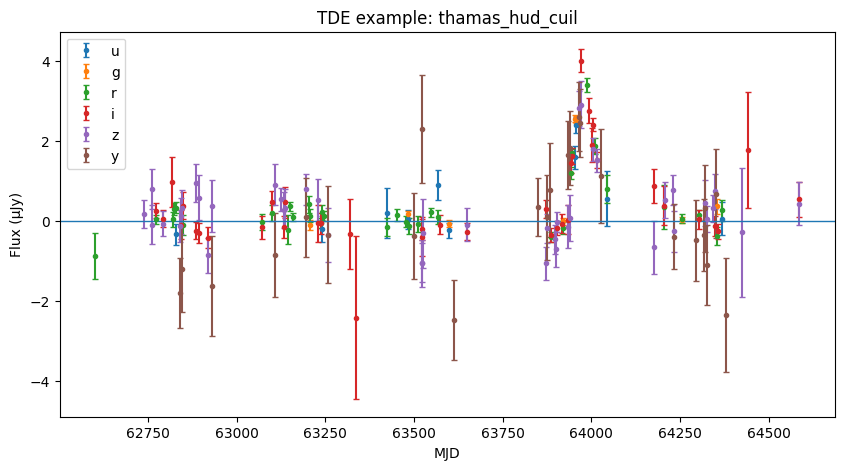

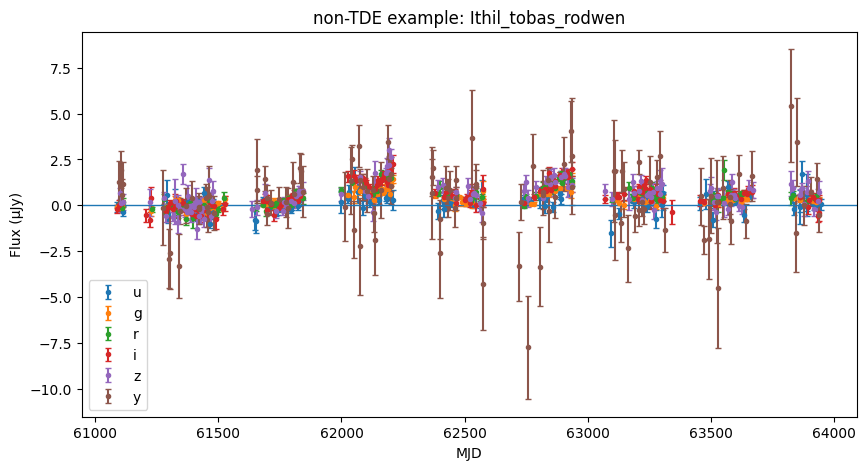

In [9]:
BANDS = ["u","g","r","i","z","y"]

def plot_lightcurve_object(lc_df, object_id, title=None):
    d = lc_df[lc_df["object_id"] == object_id].copy()
    d = d.sort_values("Time")
    plt.figure(figsize=(10,5))
    for b in BANDS:
        bb = d[d["Filter"] == b]
        if len(bb) == 0:
            continue
        plt.errorbar(bb["Time"], bb["Flux"], yerr=bb["Flux_err"],
                     fmt="o", ms=3, capsize=2, label=b)
    plt.axhline(0, linewidth=1)
    plt.xlabel("MJD")
    plt.ylabel("Flux (µJy)")
    plt.title(title or f"Lightcurve {object_id}")
    plt.legend()
    plt.show()

def show_example_pair(train_lc, train_log):
    tde_id = train_log.loc[train_log["target"]==1, "object_id"].iloc[10]
    neg_id = train_log.loc[train_log["target"]==0, "object_id"].iloc[3]
    plot_lightcurve_object(train_lc, tde_id, title=f"TDE example: {tde_id}")
    plot_lightcurve_object(train_lc, neg_id, title=f"non-TDE example: {neg_id}")

show_example_pair(train_lc, train_log)



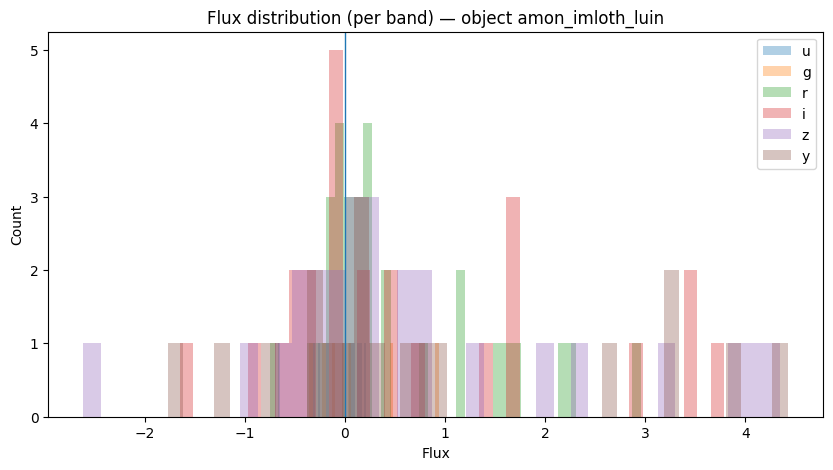

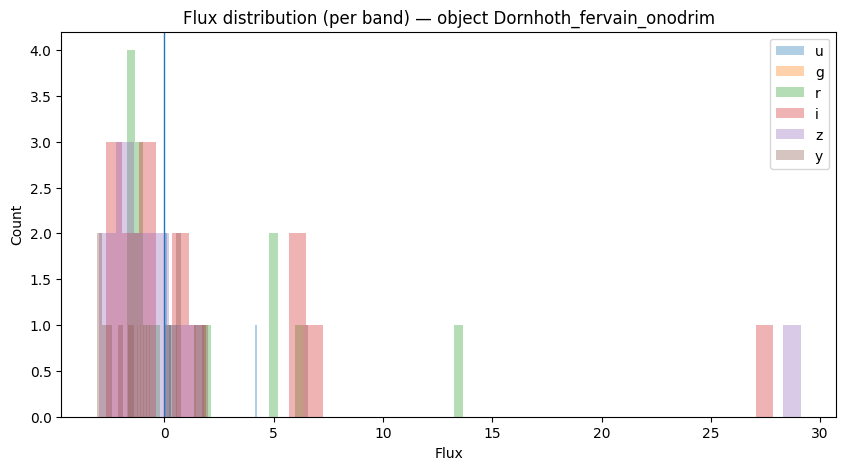

In [10]:
# vì sao cần percentile/robust stats
def plot_flux_distribution_by_band(lc_df, object_id):
    d = lc_df[lc_df["object_id"] == object_id].copy()
    plt.figure(figsize=(10,5))
    for b in BANDS:
        x = d.loc[d["Filter"]==b, "Flux"].to_numpy(np.float64)
        x = x[np.isfinite(x)]
        if x.size < 5:
            continue
        plt.hist(x, bins=40, alpha=0.35, label=b)
    plt.axvline(0, linewidth=1)
    plt.xlabel("Flux")
    plt.ylabel("Count")
    plt.title(f"Flux distribution (per band) — object {object_id}")
    plt.legend()
    plt.show()

def show_example_pair_distribution_by_band(train_lc, train_log):
    tde_id = train_log.loc[train_log["target"]==1, "object_id"].iloc[0]
    neg_id = train_log.loc[train_log["target"]==0, "object_id"].iloc[0]
    plot_flux_distribution_by_band(train_lc, tde_id)
    plot_flux_distribution_by_band(train_lc, neg_id)

show_example_pair_distribution_by_band(train_lc, train_log)


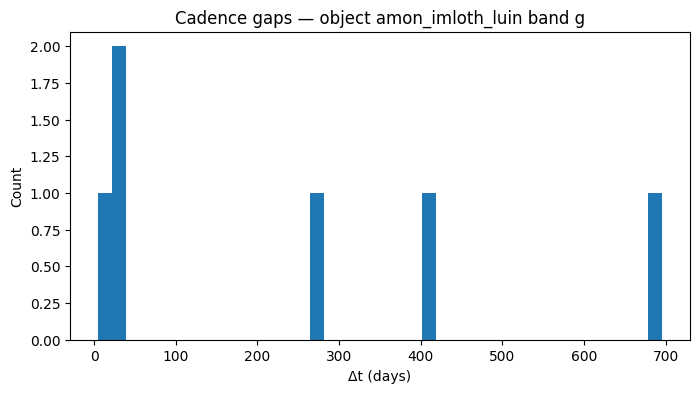

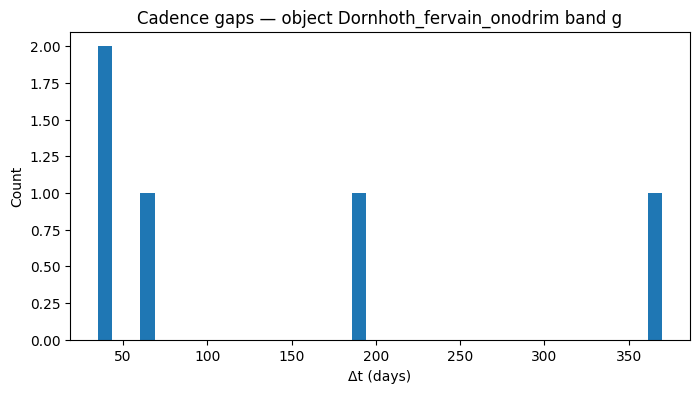

In [22]:
def plot_time_gaps(lc_df, object_id, band="g"):
    d = lc_df[(lc_df["object_id"]==object_id) & (lc_df["Filter"]==band)].sort_values("Time")
    t = d["Time"].to_numpy(np.float64)
    t = t[np.isfinite(t)]
    if t.size < 3:
        print("Not enough points")
        return
    dt = np.diff(np.sort(t))
    dt = dt[(dt>0) & np.isfinite(dt)]
    plt.figure(figsize=(8,4))
    plt.hist(dt, bins=40)
    plt.xlabel("Δt (days)")
    plt.ylabel("Count")
    plt.title(f"Cadence gaps — object {object_id} band {band}")
    plt.show()

def show_example_pair_plot_time_gaps(train_lc, train_log):
    tde_id = train_log.loc[train_log["target"]==1, "object_id"].iloc[0]
    neg_id = train_log.loc[train_log["target"]==0, "object_id"].iloc[0]
    plot_time_gaps(train_lc, tde_id)
    plot_time_gaps(train_lc, neg_id)

show_example_pair_plot_time_gaps(train_lc, train_log)


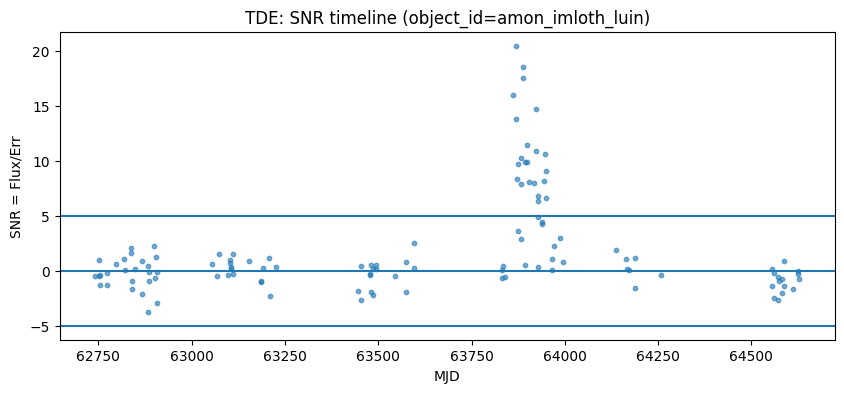

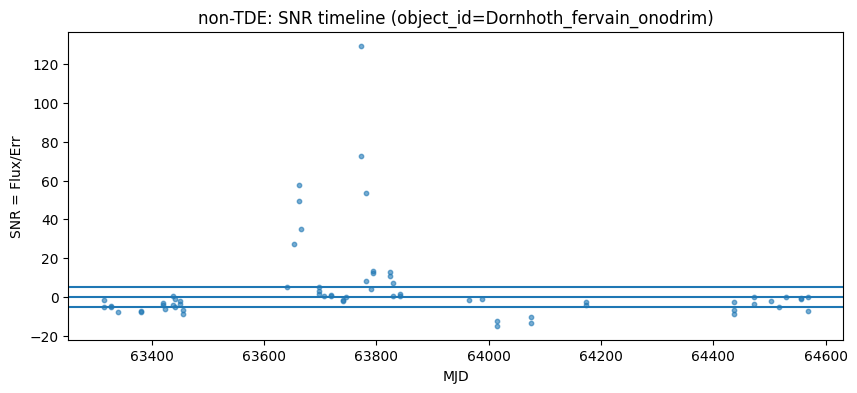

In [29]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

def pick_one(train_log, y=1):
    return train_log.loc[train_log["target"]==y, "object_id"].iloc[0]

def plot_snr_timeline(train_lc, train_log):
    oid_tde = pick_one(train_log, 1)
    oid_neg = pick_one(train_log, 0)

    def _plot(oid, title):
        d = train_lc[train_lc["object_id"]==oid].copy().sort_values("Time")
        snr = d["Flux"].to_numpy(np.float64) / np.maximum(d["Flux_err"].to_numpy(np.float64), 1e-6)
        t = d["Time"].to_numpy(np.float64)
        plt.figure(figsize=(10,4))
        plt.scatter(t, snr, s=10, alpha=0.6)
        plt.axhline(5); plt.axhline(-5); plt.axhline(0)
        plt.xlabel("MJD"); plt.ylabel("SNR = Flux/Err")
        plt.title(title + f" (object_id={oid})")
        plt.show()

    _plot(oid_tde, "TDE: SNR timeline")
    _plot(oid_neg, "non-TDE: SNR timeline")

plot_snr_timeline(train_lc, train_log)


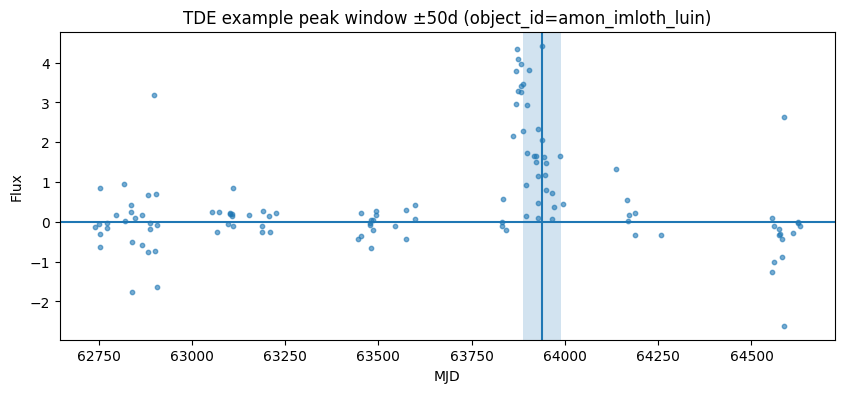

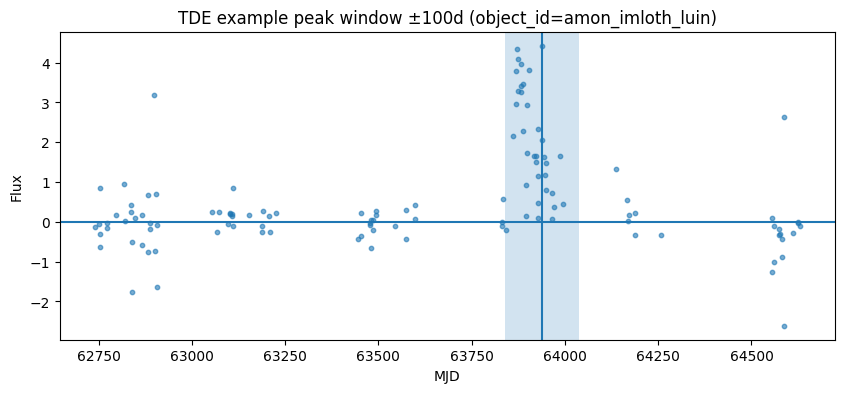

In [30]:
def plot_peak_windows(train_lc, train_log, window=100):
    oid = pick_one(train_log, 1)
    d = train_lc[train_lc["object_id"]==oid].copy().sort_values("Time")
    t = d["Time"].to_numpy(np.float64)
    f = d["Flux"].to_numpy(np.float64)

    t_peak = t[int(np.nanargmax(np.abs(f)))]
    plt.figure(figsize=(10,4))
    plt.scatter(t, f, s=10, alpha=0.6)
    plt.axvline(t_peak)
    plt.axvspan(t_peak-window, t_peak+window, alpha=0.2)
    plt.axhline(0)
    plt.xlabel("MJD"); plt.ylabel("Flux")
    plt.title(f"TDE example peak window ±{window}d (object_id={oid})")
    plt.show()

plot_peak_windows(train_lc, train_log, window=50)
plot_peak_windows(train_lc, train_log, window=100)



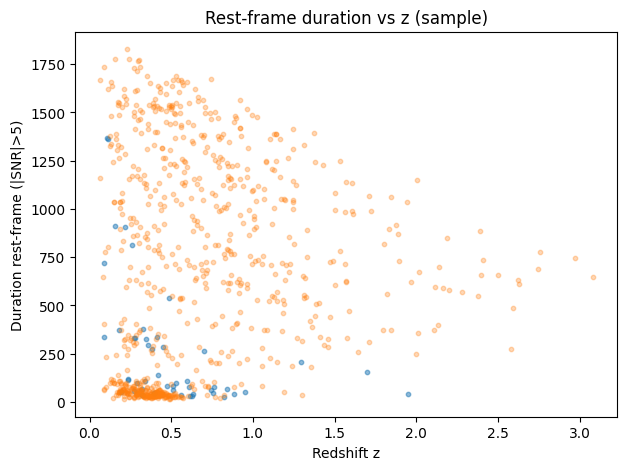

In [31]:
def plot_restframe_duration_vs_z(train_lc, train_log):
    # lấy sample nhỏ cho nhanh
    df = train_log[["object_id","Z","target"]].copy()
    df["Z"] = pd.to_numeric(df["Z"], errors="coerce")
    df = df.dropna(subset=["Z"]).sample(800, random_state=0)

    # tính duration 5-sigma (obs-frame) và rest-frame
    rows = []
    for oid, z, y in df[["object_id","Z","target"]].itertuples(index=False):
        d = train_lc[train_lc["object_id"]==oid]
        if len(d) < 8: 
            continue
        t = d["Time"].to_numpy(np.float64)
        f = d["Flux"].to_numpy(np.float64)
        e = np.maximum(d["Flux_err"].to_numpy(np.float64), 1e-6)
        m = np.isfinite(t)&np.isfinite(f)&np.isfinite(e)
        t,f,e = t[m],f[m],e[m]
        if t.size < 8: 
            continue
        snr = np.abs(f)/e
        hi = snr>5
        dur = (t[hi].max()-t[hi].min()) if hi.sum()>=2 else 0.0
        rows.append((z, y, dur, dur/(1+max(z,0))))
    out = pd.DataFrame(rows, columns=["z","target","dur5_obs","dur5_rest"])

    plt.figure(figsize=(7,5))
    plt.scatter(out.loc[out["target"]==1,"z"], out.loc[out["target"]==1,"dur5_rest"], s=10, alpha=0.5)
    plt.scatter(out.loc[out["target"]==0,"z"], out.loc[out["target"]==0,"dur5_rest"], s=10, alpha=0.3)
    plt.xlabel("Redshift z"); plt.ylabel("Duration rest-frame (|SNR|>5)")
    plt.title("Rest-frame duration vs z (sample)")
    plt.show()

plot_restframe_duration_vs_z(train_lc, train_log)



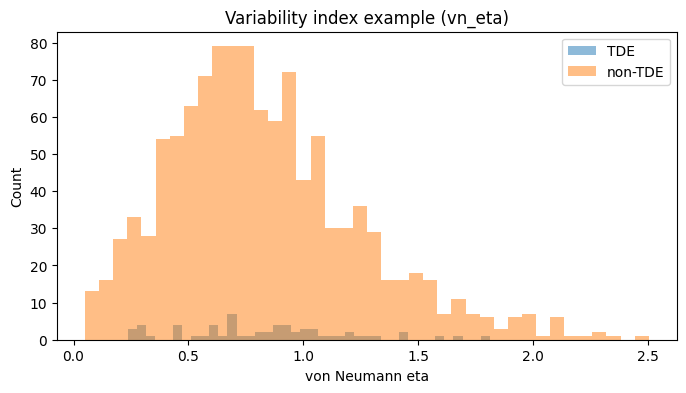

In [32]:
from scipy import stats as sp_stats

def compute_vn_eta_for_object(d):
    d = d.sort_values("Time")
    f = d["Flux"].to_numpy(np.float64)
    f = f[np.isfinite(f)]
    if f.size < 10:
        return 0.0
    df1 = np.diff(f)
    var = np.var(f) + 1e-12
    return float(np.mean(df1*df1)/var) if df1.size else 0.0

def plot_variability_index_hist(train_lc, train_log):
    sample = train_log.sample(1200, random_state=0)[["object_id","target"]]
    vals = []
    for oid, y in sample.itertuples(index=False):
        d = train_lc[train_lc["object_id"]==oid]
        vals.append((y, compute_vn_eta_for_object(d)))
    out = pd.DataFrame(vals, columns=["target","vn_eta"])

    plt.figure(figsize=(8,4))
    plt.hist(out.loc[out["target"]==1,"vn_eta"], bins=40, alpha=0.5, label="TDE")
    plt.hist(out.loc[out["target"]==0,"vn_eta"], bins=40, alpha=0.5, label="non-TDE")
    plt.xlabel("von Neumann eta"); plt.ylabel("Count")
    plt.title("Variability index example (vn_eta)")
    plt.legend()
    plt.show()

plot_variability_index_hist(train_lc, train_log)


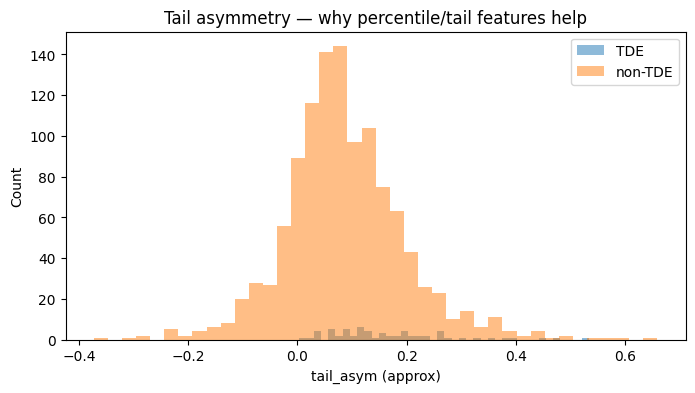

In [33]:
def approx_tail_asym(d):
    # đơn giản: gom tất cả band, lấy median baseline, nhìn tail
    f = d["Flux"].to_numpy(np.float64)
    f = f[np.isfinite(f)]
    if f.size < 30:
        return 0.0
    base = np.median(f)
    x = f - base
    p10, p50, p90 = np.percentile(x, [10,50,90])
    amp = (x.max()-x.min()) + 1e-6
    tail_hi = (p90-p50)/amp
    tail_lo = (p50-p10)/amp
    return float(tail_hi - tail_lo)

def plot_tail_asym_hist(train_lc, train_log):
    sample = train_log.sample(1200, random_state=1)[["object_id","target"]]
    vals=[]
    for oid,y in sample.itertuples(index=False):
        d=train_lc[train_lc["object_id"]==oid]
        vals.append((y, approx_tail_asym(d)))
    out=pd.DataFrame(vals, columns=["target","tail_asym"])

    plt.figure(figsize=(8,4))
    plt.hist(out.loc[out["target"]==1,"tail_asym"], bins=40, alpha=0.5, label="TDE")
    plt.hist(out.loc[out["target"]==0,"tail_asym"], bins=40, alpha=0.5, label="non-TDE")
    plt.xlabel("tail_asym (approx)"); plt.ylabel("Count")
    plt.title("Tail asymmetry — why percentile/tail features help")
    plt.legend(); plt.show()

plot_tail_asym_hist(train_lc, train_log)


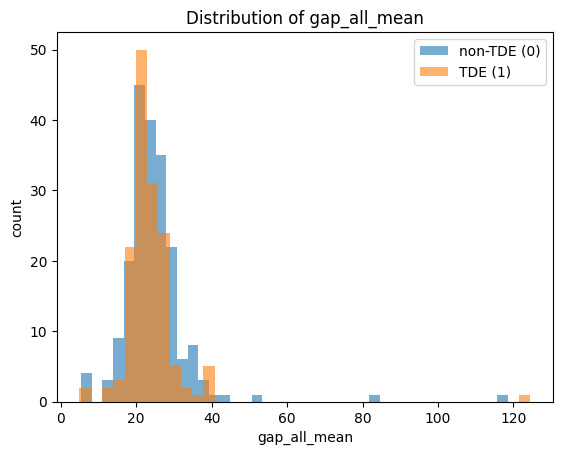

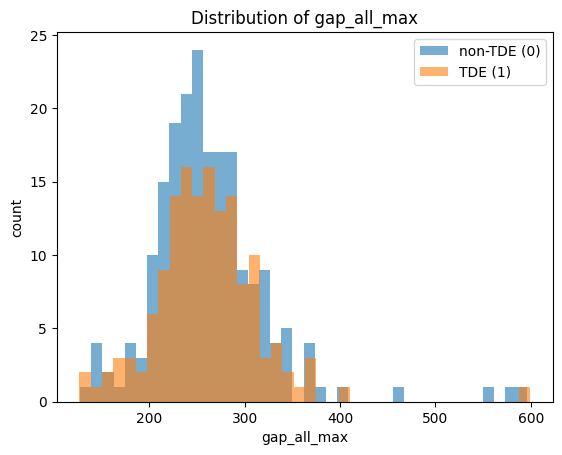

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def compute_global_gaps_for_many(lc_df, object_ids):
    rows = []
    for oid in object_ids:
        sub = lc_df[lc_df["object_id"] == oid]
        t = sub["Time"].to_numpy(np.float64)
        t = t[np.isfinite(t)]
        if t.size < 3:
            rows.append({"object_id": oid, "gap_all_mean": 0.0, "gap_all_std": 0.0, "gap_all_max": 0.0})
            continue
        t = np.sort(t)
        dt = np.diff(t)
        dt = dt[np.isfinite(dt) & (dt > 0)]
        if dt.size == 0:
            rows.append({"object_id": oid, "gap_all_mean": 0.0, "gap_all_std": 0.0, "gap_all_max": 0.0})
            continue
        rows.append({
            "object_id": oid,
            "gap_all_mean": float(dt.mean()),
            "gap_all_std": float(dt.std()),
            "gap_all_max": float(dt.max()),
        })
    return pd.DataFrame(rows)

def plot_gap_distributions(train_lc, train_log, n_each=200, seed=42):
    rng = np.random.default_rng(seed)

    pos_ids = train_log.loc[train_log["target"] == 1, "object_id"].to_numpy()
    neg_ids = train_log.loc[train_log["target"] == 0, "object_id"].to_numpy()

    pos_sample = rng.choice(pos_ids, size=min(n_each, pos_ids.size), replace=False)
    neg_sample = rng.choice(neg_ids, size=min(n_each, neg_ids.size), replace=False)

    df_pos = compute_global_gaps_for_many(train_lc, pos_sample)
    df_neg = compute_global_gaps_for_many(train_lc, neg_sample)

    for col in ["gap_all_mean", "gap_all_max"]:
        plt.figure()
        plt.hist(df_neg[col], bins=40, alpha=0.6, label="non-TDE (0)")
        plt.hist(df_pos[col], bins=40, alpha=0.6, label="TDE (1)")
        plt.xlabel(col)
        plt.ylabel("count")
        plt.title(f"Distribution of {col}")
        plt.legend()
        plt.show()

# --- CALL luôn ---
plot_gap_distributions(train_lc, train_log, n_each=200)


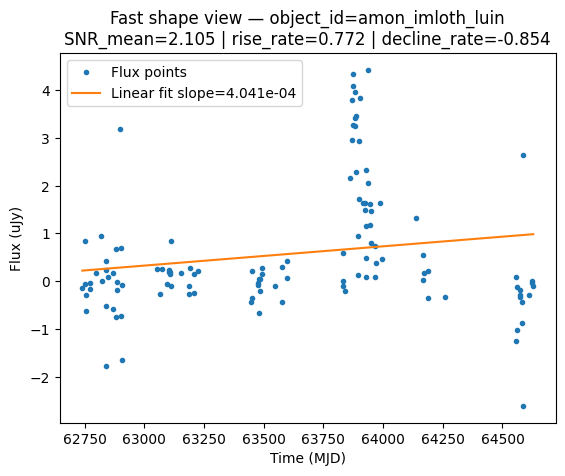

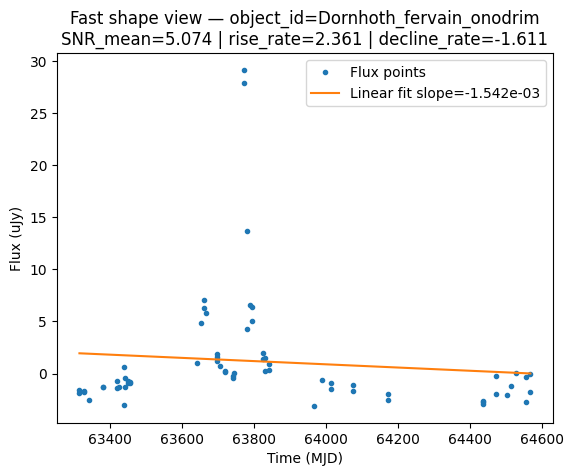

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_fast_shape_one_object(lc_df, obj_id):
    sub = lc_df[lc_df["object_id"] == obj_id].copy()
    sub = sub.sort_values("Time")
    t = sub["Time"].to_numpy(np.float64)
    f = sub["Flux"].to_numpy(np.float64)
    e = np.maximum(sub["Flux_err"].to_numpy(np.float64), 1e-6)

    m = np.isfinite(t) & np.isfinite(f) & np.isfinite(e)
    t, f, e = t[m], f[m], e[m]
    if t.size < 8:
        print("Too few points.")
        return

    # linear fit
    a, b = np.polyfit(t, f, 1)
    fhat = a*t + b

    # rise/decline diffs
    df = np.diff(f)
    rise = df[df > 0]
    decline = df[df < 0]

    plt.figure()
    plt.plot(t, f, ".", label="Flux points")
    plt.plot(t, fhat, "-", label=f"Linear fit slope={a:.3e}")
    plt.xlabel("Time (MJD)")
    plt.ylabel("Flux (uJy)")
    plt.title(f"Fast shape view — object_id={obj_id}\n"
              f"SNR_mean={np.mean(f/e):.3f} | rise_rate={rise.mean() if rise.size else 0:.3f} | "
              f"decline_rate={decline.mean() if decline.size else 0:.3f}")
    plt.legend()
    plt.show()

# --- CALL: 1 TDE và 1 non-TDE ---
tde_id = train_log.loc[train_log["target"]==1, "object_id"].iloc[0]
non_id = train_log.loc[train_log["target"]==0, "object_id"].iloc[0]
plot_fast_shape_one_object(train_lc, tde_id)
plot_fast_shape_one_object(train_lc, non_id)


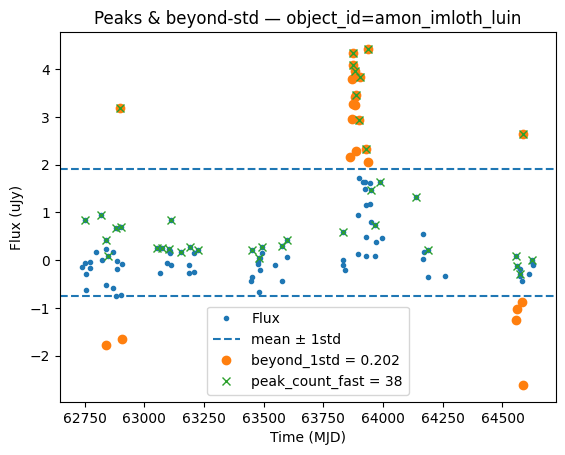

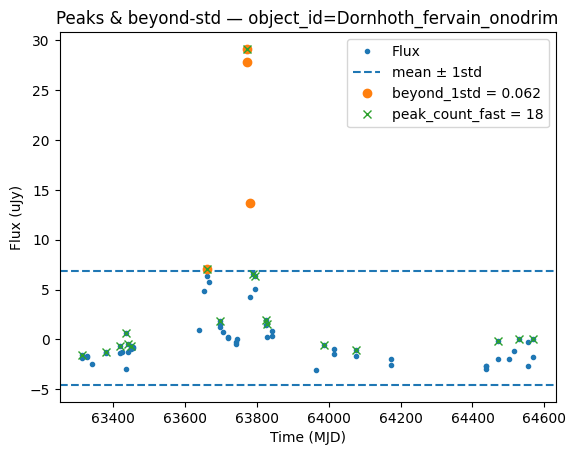

In [41]:
def plot_peaks_and_beyond_one_object(lc_df, obj_id):
    sub = lc_df[lc_df["object_id"] == obj_id].copy().sort_values("Time")
    t = sub["Time"].to_numpy(np.float64)
    f = sub["Flux"].to_numpy(np.float64)

    m = np.isfinite(t) & np.isfinite(f)
    t, f = t[m], f[m]
    if f.size < 8:
        print("Too few points.")
        return

    mu, sd = f.mean(), f.std()
    beyond_mask = np.abs(f - mu) > sd if sd > 0 else np.zeros_like(f, dtype=bool)

    # local peaks
    peak_mask = np.zeros_like(f, dtype=bool)
    if f.size >= 3:
        peak_mask[1:-1] = (f[1:-1] > f[:-2]) & (f[1:-1] > f[2:])

    plt.figure()
    plt.plot(t, f, ".", label="Flux")
    if sd > 0:
        plt.axhline(mu + sd, linestyle="--", label="mean ± 1std")
        plt.axhline(mu - sd, linestyle="--")
    plt.plot(t[beyond_mask], f[beyond_mask], "o", label=f"beyond_1std = {beyond_mask.mean():.3f}")
    plt.plot(t[peak_mask], f[peak_mask], "x", label=f"peak_count_fast = {peak_mask.sum()}")
    plt.xlabel("Time (MJD)")
    plt.ylabel("Flux (uJy)")
    plt.title(f"Peaks & beyond-std — object_id={obj_id}")
    plt.legend()
    plt.show()

plot_peaks_and_beyond_one_object(train_lc, tde_id)
plot_peaks_and_beyond_one_object(train_lc, non_id)



Khối 7: Training

In [23]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import re

# 1. Load dữ liệu (nếu chưa có trong memory)
# train_df = pd.read_parquet("train_feat.parquet")
# test_df = pd.read_parquet("test_feat.parquet")

train_df = train_feat.copy()
test_df = test_feat.copy()

# 2. Làm sạch tên cột (LightGBM không thích tên cột chứa ký tự đặc biệt JSON)
train_df.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in train_df.columns]
test_df.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in test_df.columns]

# 3. Tách Feature và Target
# Loại bỏ các cột không dùng để train (ID, Target)
excluded_cols = ['object_id', 'target', 'split'] 
features = [c for c in train_df.columns if c not in excluded_cols]

X = train_df[features]
y = train_df['target']
X_test = test_df[features]

print(f"Số lượng features: {len(features)}")
print(f"Tỷ lệ TDE (Target=1): {y.mean():.4%}")

Số lượng features: 291
Tỷ lệ TDE (Target=1): 4.8636%


In [13]:
import optuna
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import numpy as np

# Tắt bớt log của LightGBM để đỡ rối mắt khi Optuna chạy
optuna.logging.set_verbosity(optuna.logging.INFO)

def objective(trial):
    """
    Hàm mục tiêu mà Optuna sẽ cố gắng tối đa hóa (Maximize AUC)
    """
    # 1. Định nghĩa không gian tham số (Search Space)
    param_grid = {
        'objective': 'binary',
        'metric': 'auc',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'n_estimators': 2000,
        'random_state': 42,
        'n_jobs': -1,
        'is_unbalance': True, # Giữ nguyên xử lý mất cân bằng
        
        # Các tham số cần tối ưu:
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 128),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-4, 10.0, log=True),  # L1 Regularization
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-4, 10.0, log=True) # L2 Regularization
    }

    # 2. Cross-Validation nội bộ (3 Folds để chạy nhanh)
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    aucs = []

    # Loop qua các folds
    for trn_idx, val_idx in cv.split(X, y):
        X_trn, y_trn = X.iloc[trn_idx], y.iloc[trn_idx]
        X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

        # Train model
        model = lgb.LGBMClassifier(**param_grid)
        model.fit(
            X_trn, y_trn,
            eval_set=[(X_val, y_val)],
            eval_metric='auc',
            callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
        )
        
        # Dự đoán và tính AUC
        preds = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, preds)
        aucs.append(auc)

    # Trả về AUC trung bình của 3 folds
    return np.mean(aucs)

# --- BẮT ĐẦU TỐI ƯU HÓA ---
print("Đang chạy Optuna... (Có thể mất vài phút)")
study = optuna.create_study(direction='maximize', study_name='TDE_LightGBM_Optimization')
study.optimize(objective, n_trials=30) # Chạy thử 30 bộ tham số khác nhau

print("\n------------------------------------------------")
print("Đã tìm thấy tham số tốt nhất:")
print(study.best_params)
print(f"Best CV AUC: {study.best_value:.5f}")
print("------------------------------------------------")

[I 2025-12-23 07:27:42,328] A new study created in memory with name: TDE_LightGBM_Optimization


Đang chạy Optuna... (Có thể mất vài phút)


[I 2025-12-23 07:27:45,616] Trial 0 finished with value: 0.9431801487434353 and parameters: {'learning_rate': 0.04355026755237718, 'num_leaves': 74, 'max_depth': 8, 'min_child_samples': 91, 'subsample': 0.7264978120626822, 'colsample_bytree': 0.6091981318238153, 'reg_alpha': 0.10823066810661594, 'reg_lambda': 0.08945261104026134}. Best is trial 0 with value: 0.9431801487434353.
[I 2025-12-23 07:27:48,738] Trial 1 finished with value: 0.9411912163829262 and parameters: {'learning_rate': 0.04870368014865206, 'num_leaves': 73, 'max_depth': 11, 'min_child_samples': 97, 'subsample': 0.7524632174199368, 'colsample_bytree': 0.7900124177782117, 'reg_alpha': 0.0005199241734347449, 'reg_lambda': 0.01459213921788331}. Best is trial 0 with value: 0.9431801487434353.
[I 2025-12-23 07:27:53,477] Trial 2 finished with value: 0.9423502872651652 and parameters: {'learning_rate': 0.05991440534339624, 'num_leaves': 124, 'max_depth': 10, 'min_child_samples': 65, 'subsample': 0.5433907012530252, 'colsample


------------------------------------------------
Đã tìm thấy tham số tốt nhất:
{'learning_rate': 0.02677158033988965, 'num_leaves': 93, 'max_depth': 12, 'min_child_samples': 53, 'subsample': 0.8233971480971053, 'colsample_bytree': 0.7198404392784453, 'reg_alpha': 1.1562511246515568, 'reg_lambda': 0.0008519555989364349}
Best CV AUC: 0.95011
------------------------------------------------


In [14]:
best_params = study.best_params

# Bổ sung các tham số cố định (không nằm trong search space)
best_params['objective'] = 'binary'
best_params['metric'] = ['auc', 'binary_logloss']
best_params['boosting_type'] = 'gbdt'
best_params['n_estimators'] = 2000
best_params['random_state'] = 42
best_params['n_jobs'] = -1
best_params['is_unbalance'] = True # Quan trọng

# Khởi tạo K-Fold
n_folds = 5
folds = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

# Mảng lưu kết quả
oof_preds = np.zeros(len(X))       # Out-of-Fold predictions (để tính CV score)
test_preds = np.zeros(len(X_test)) # Predictions trên tập test
feature_importance_df = pd.DataFrame()

print("Bắt đầu training...")

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X, y)):
    print(f"--- Fold {fold_ + 1} / {n_folds} ---")
    
    X_trn, y_trn = X.iloc[trn_idx], y.iloc[trn_idx]
    X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
    
    # Khởi tạo mô hình
    clf = lgb.LGBMClassifier(**best_params)
    
    # Train với Early Stopping (dừng nếu không cải thiện sau 100 vòng)
    clf.fit(
        X_trn, y_trn,
        eval_set=[(X_trn, y_trn), (X_val, y_val)],
        eval_metric='auc',
        callbacks=[lgb.early_stopping(stopping_rounds=100), lgb.log_evaluation(500)]
    )
    
    # Dự đoán trên tập Val
    val_pred = clf.predict_proba(X_val)[:, 1]
    oof_preds[val_idx] = val_pred
    
    # Dự đoán trên tập Test (cộng dồn để lấy trung bình sau này)
    test_preds += clf.predict_proba(X_test)[:, 1] / n_folds
    
    # Lưu độ quan trọng feature
    fold_importance = pd.DataFrame()
    fold_importance["feature"] = features
    fold_importance["importance"] = clf.feature_importances_
    fold_importance["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance], axis=0)

# Đánh giá tổng thể
cv_auc = roc_auc_score(y, oof_preds)
print(f"\n✅ TỔNG KẾT CV AUC SCORE: {cv_auc:.5f}")

Bắt đầu training...
--- Fold 1 / 5 ---
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[140]	training's auc: 0.999985	training's binary_logloss: 0.0418427	valid_1's auc: 0.963673	valid_1's binary_logloss: 0.102327
--- Fold 2 / 5 ---
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[237]	training's auc: 1	training's binary_logloss: 0.0156803	valid_1's auc: 0.954231	valid_1's binary_logloss: 0.107801
--- Fold 3 / 5 ---
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[204]	training's auc: 1	training's binary_logloss: 0.0223321	valid_1's auc: 0.946459	valid_1's binary_logloss: 0.106462
--- Fold 4 / 5 ---
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[306]	training's auc: 1	training's binary_logloss: 0.00967164	valid_1's auc: 0.923769	valid_1's binary_logloss: 0.131728
--- Fold 5 / 5 ---
Training 

Đang quét tìm ngưỡng cắt tốt nhất cho LightGBM...


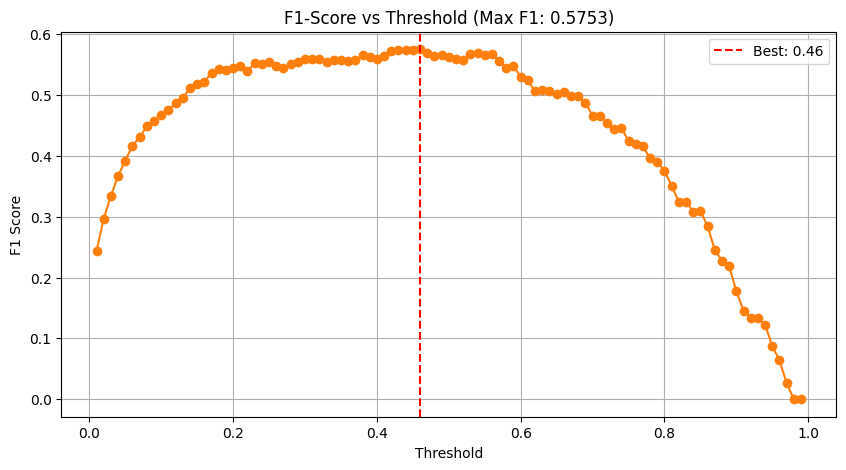


✅ NGƯỠNG TỐI ƯU CỦA LIGHTGBM LÀ: 0.46
   (Tại ngưỡng này, F1-Score trên tập Val đạt: 0.5753)


In [24]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# BƯỚC 1: Tìm ngưỡng tối ưu trên tập Validation (OOF Data)
# ---------------------------------------------------------
# Chúng ta sẽ thử chạy threshold từ 0.01 đến 0.99 xem cái nào cho F1-Score cao nhất

thresholds = np.arange(0.01, 1.00, 0.01)
scores = []
best_thresh = 0.5
best_score = 0

print("Đang quét tìm ngưỡng cắt tốt nhất cho LightGBM...")

for thresh in thresholds:
    # Chuyển xác suất thành nhãn 0/1 tại ngưỡng này
    # Lưu ý: oof_preds là biến chứa xác suất dự đoán trên tập Train/Val
    preds_bin = (oof_preds > thresh).astype(int)
    
    # Tính F1-Score (Quan trọng hơn Accuracy khi dữ liệu lệch)
    score = f1_score(y, preds_bin)
    scores.append(score)
    
    if score > best_score:
        best_score = score
        best_thresh = thresh
# Vẽ biểu đồ để bạn đưa vào báo cáo
plt.figure(figsize=(10, 5))
plt.plot(thresholds, scores, '-o', color='tab:orange')
plt.axvline(best_thresh, color='red', linestyle='--', label=f'Best: {best_thresh:.2f}')
plt.title(f'F1-Score vs Threshold (Max F1: {best_score:.4f})')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()

print(f"\n✅ NGƯỠNG TỐI ƯU CỦA LIGHTGBM LÀ: {best_thresh}")
print(f"   (Tại ngưỡng này, F1-Score trên tập Val đạt: {best_score:.4f})")

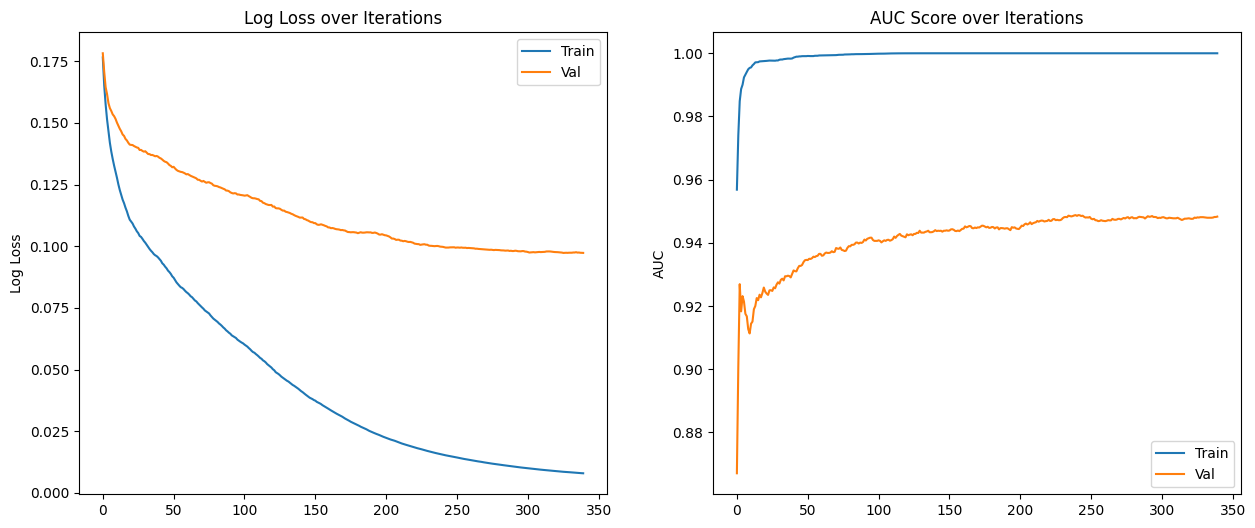

In [16]:
# Giả sử bạn đã train xong biến 'clf' như code trước
# clf.evals_result_ chứa lịch sử training
results = clf.evals_result_

def plot_learning_curve(results):
    epochs = len(results['training']['auc'])
    x_axis = range(0, epochs)
    
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    
    # Biểu đồ Log Loss
    ax[0].plot(x_axis, results['training']['binary_logloss'], label='Train')
    ax[0].plot(x_axis, results['valid_1']['binary_logloss'], label='Val')
    ax[0].legend()
    ax[0].set_title('Log Loss over Iterations')
    ax[0].set_ylabel('Log Loss')
    
    # Biểu đồ AUC
    ax[1].plot(x_axis, results['training']['auc'], label='Train')
    ax[1].plot(x_axis, results['valid_1']['auc'], label='Val')
    ax[1].legend()
    ax[1].set_title('AUC Score over Iterations')
    ax[1].set_ylabel('AUC')
    
    plt.show()

plot_learning_curve(results)


Báo cáo chi tiết (Threshold = 0.36000000000000004):
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2895
           1       0.58      0.57      0.58       148

    accuracy                           0.96      3043
   macro avg       0.78      0.77      0.78      3043
weighted avg       0.96      0.96      0.96      3043



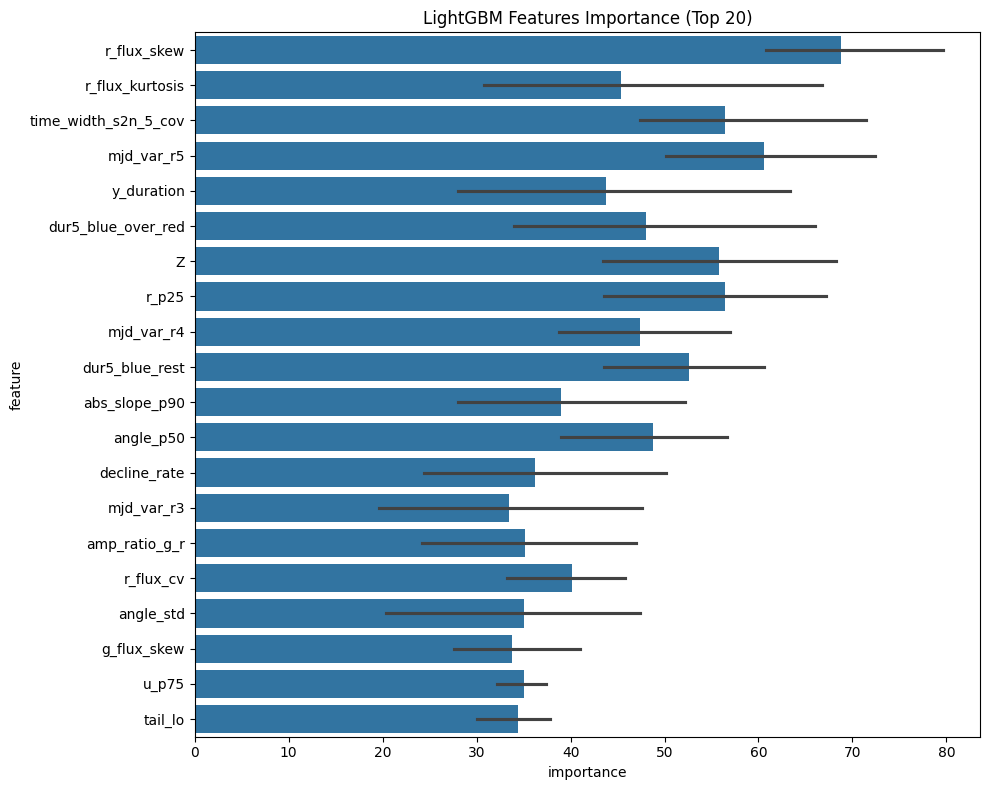

In [25]:
# 1. Báo cáo phân loại (Classification Report) tại ngưỡng 0.5
print("\nBáo cáo chi tiết (Threshold = 0.46):")
print(classification_report(y, (oof_preds > 0.46).astype(int)))

# 2. Vẽ Feature Importance (Top 20 quan trọng nhất)
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:20].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(10, 8))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features Importance (Top 20)')
plt.tight_layout()
plt.show() # Bạn chụp ảnh này đưa vào báo cáo

In [27]:
threshold = 0.46
binary_predictions = (test_preds > threshold).astype(int)

# 2. Tạo DataFrame submission
submission = pd.DataFrame({
    'object_id': test_df['object_id'],
    'target': binary_predictions  # Cột này chứa giá trị 0 hoặc 1
})

# 3. Kiểm tra định dạng
print(submission.head())
print(submission['target'].value_counts()) # Xem tỷ lệ dự đoán 0 và 1

# 4. Lưu file
submission.to_csv("submission_tde_binary.csv", index=False)
print("Đã lưu file: submission_tde_binary.csv")

                object_id  target
0    Dornhoth_adar_imrath       0
1    Dornhoth_celeb_achad       0
2    Dornhoth_firion_fern       0
3      Dornhoth_glae_aras       1
4  Dornhoth_lain_tinuviel       1
target
0    6789
1     346
Name: count, dtype: int64
Đã lưu file: submission_tde_binary.csv


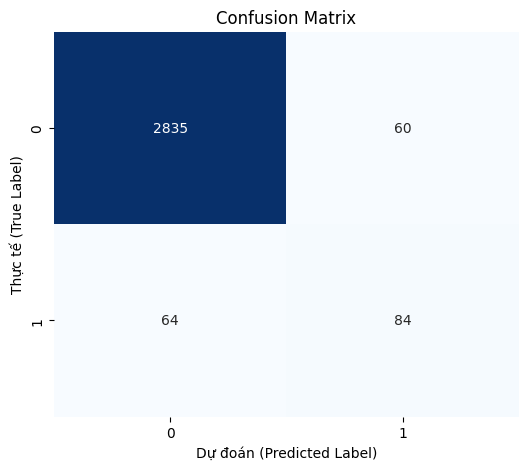

In [26]:
def plot_confusion_matrix(y_true, y_pred_binary):
    cm = confusion_matrix(y_true, y_pred_binary)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title("Confusion Matrix")
    plt.ylabel('Thực tế (True Label)')
    plt.xlabel('Dự đoán (Predicted Label)')
    plt.show()

# Lưu ý: Cần chọn threshold phù hợp (ví dụ 0.5 hoặc threshold tối ưu bạn tìm được)
plot_confusion_matrix(y, (oof_preds > 0.46).astype(int))

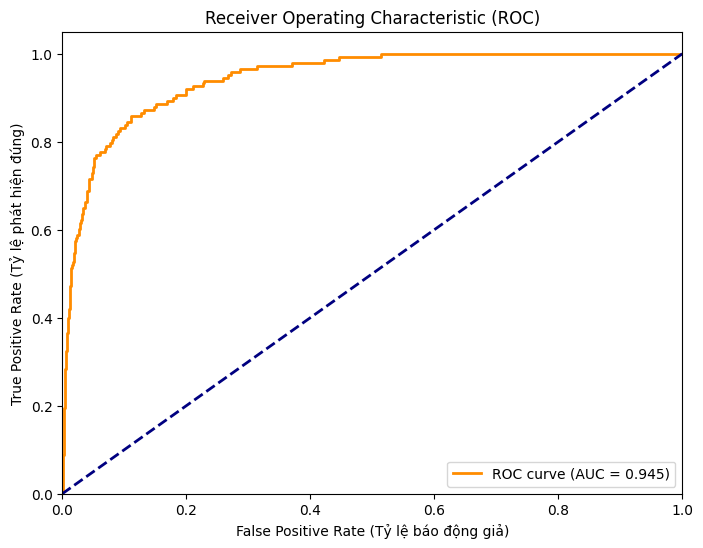

In [28]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, y_pred_prob):
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # Đường ngẫu nhiên
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (Tỷ lệ báo động giả)')
    plt.ylabel('True Positive Rate (Tỷ lệ phát hiện đúng)')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

# Sử dụng oof_preds (dự đoán trên tập validation tổng hợp)
plot_roc_curve(y, oof_preds)